In [1]:
import docx
import os

import re
import pandas as pd
import numpy as np

# nltk
from nltk import tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn')
# plt.style.use('grayscale')
%matplotlib inline

In [2]:
novel = []

for filename in os.listdir('text'):
    if filename == 'istanbul hatirasi ingilizce.docx':
        continue
    try:
        matches = re.search(r'([0-9]*)_([a-z]*)_', filename)
        position = int(matches[1])
        period = matches[2].replace('distant', 'Distant History')\
                           .replace('recent', 'Modern History')\
                           .replace('current', 'Present Day')\
                           .replace('detectivestory', 'Detective Story')
        doc = docx.Document('text/{}'.format(filename))
        text = '\n\n'.join(paragraph.text for paragraph in doc.paragraphs)
        novel.append([position, period, text])
    except TypeError:
        print(filename)

novel = sorted(novel, key=lambda x: x[0])

In [3]:
analyzer = SentimentIntensityAnalyzer()

In [4]:
# Take average sentiment of each sentence in a section

# for section in novel:
#     sentences = tokenize.sent_tokenize(section[2])
#     sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}

#     for sentence in sentences:
#         vs = analyzer.polarity_scores(sentence)
#         sentiments['compound'] += vs['compound']
#         sentiments['neg'] += vs['neg']
#         sentiments['neu'] += vs['neu']
#         sentiments['pos'] += vs['pos']

#     sentiments['compound'] = sentiments['compound'] / len(sentences)
#     sentiments['neg'] = sentiments['neg'] / len(sentences)
#     sentiments['neu'] = sentiments['neu'] / len(sentences)
#     sentiments['pos'] = sentiments['pos'] / len(sentences)
#     section.append(len(sentences))
#     section.append(sentiments)

In [5]:
# Take average sentiment of n most extreme sentences in a section

for section in novel:
    sentences = tokenize.sent_tokenize(section[2])
    sentiments = {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
    compound = []
    neg = []
    neu = []
    pos = []

    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        compound.append((vs['compound'], sentence))
        sentiments['neg'] += vs['neg']
        sentiments['neu'] += vs['neu']
        sentiments['pos'] += vs['pos']
        
    compound = sorted(compound, reverse=True, key=lambda x: abs(x[0]))[:10]  # n most extreme sentences
    
    for sentence in [element[1] for element in compound]:
        vs = analyzer.polarity_scores(sentence)
        sentiments['compound'] += vs['compound']

    sentiments['compound'] = sentiments['compound'] / len(compound)
    sentiments['neg'] = sentiments['neg'] / len(sentences)
    sentiments['neu'] = sentiments['neu'] / len(sentences)
    sentiments['pos'] = sentiments['pos'] / len(sentences)
    section.append(len(sentences))
    section.append(sentiments)

In [6]:
df = pd.DataFrame({'section': [section[0] for section in novel],
                   'period': [section[1] for section in novel],
                   'text': [section[2] for section in novel],
                   'sentence_count': [section[3] for section in novel],
                   'compound': [section[4]['compound'] for section in novel],
                   'pos': [section[4]['pos'] for section in novel],
                   'neg': [section[4]['neg'] for section in novel],
                   'neu': [section[4]['neu'] for section in novel]})

In [7]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465


In [8]:
df.describe()

,section,sentence_count,compound,pos,neg,neu
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,154.500000,36.863636,0.070684,0.075490,0.050623,0.873884
std,89.056162,88.643749,0.295873,0.050890,0.042271,0.063892
min,1.000000,1.000000,-0.890370,0.000000,0.000000,0.667000
25%,77.750000,3.000000,-0.079365,0.043923,0.016458,0.835789
50%,154.500000,7.500000,0.046785,0.068167,0.048696,0.870278
75%,231.250000,31.000000,0.232272,0.097921,0.077300,0.912536
max,308.000000,816.000000,0.907290,0.299667,0.292500,1.000000


In [9]:
chapter_breaks = []
sentence_count = 0
for sentence in tokenize.sent_tokenize((' ').join([entry[2] for entry in novel])):
    if '\n\n\n\n' in sentence:
        chapter_breaks.append(sentence_count)
    sentence_count += 1

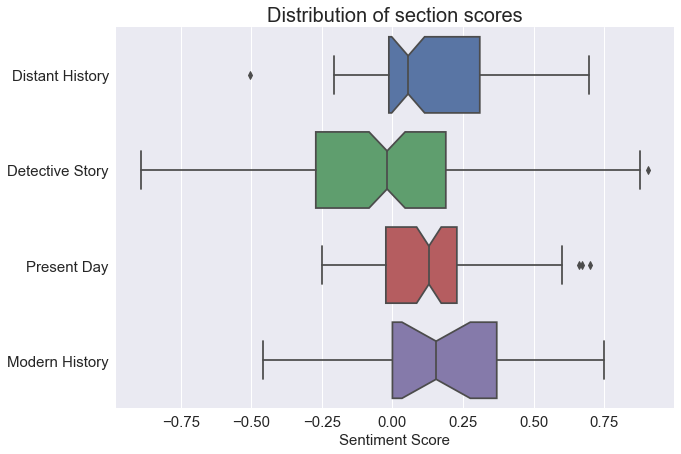

In [10]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df, notch=True)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(boxplot.jpg, dpi=300)
plt.show()

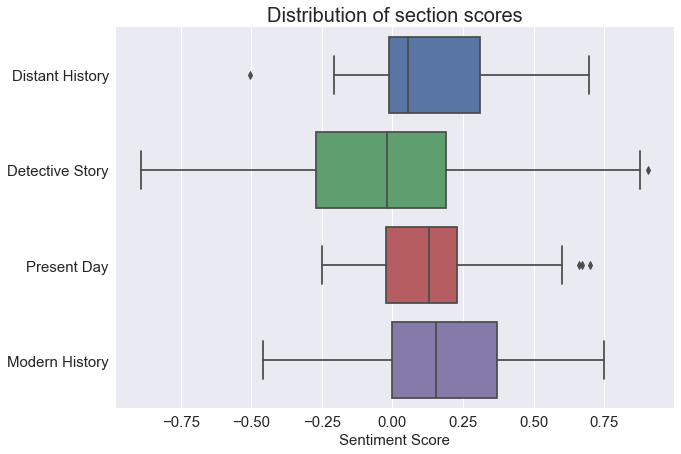

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df, notch=False)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(boxplot.jpg, dpi=300)
plt.show()

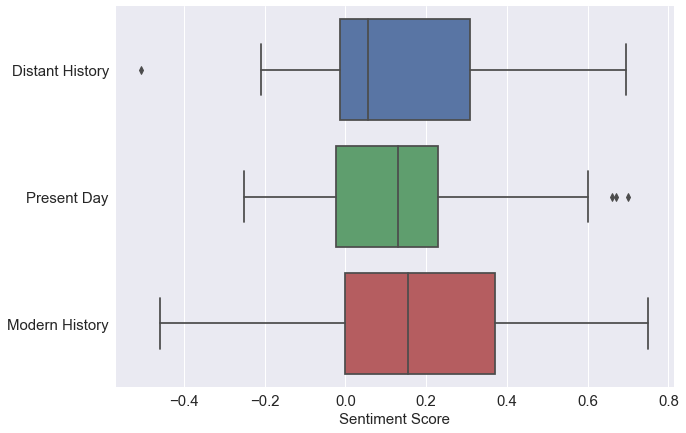

In [12]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='compound', y='period', data=df[df['period'].isin(['Distant History', 'Modern History', 'Present Day'])], notch=False)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
# plt.title('Distribution of sentiment scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(boxplot.jpg, dpi=300)
plt.show()

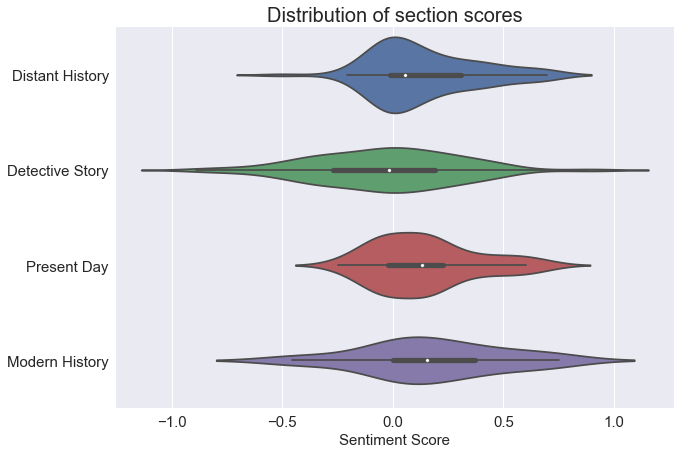

In [13]:
plt.figure(figsize=(10, 7))
sns.violinplot(x='compound', y='period', data=df, notch=True)
plt.xlabel('Sentiment Score', fontsize=15)
plt.ylabel('')
plt.title('Distribution of section scores', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [14]:
book_indices = {}
idx = 0
for section in novel:
    start = idx
    idx += section[3]
    book_indices[section[0]] = (start, idx, section[1])

In [15]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

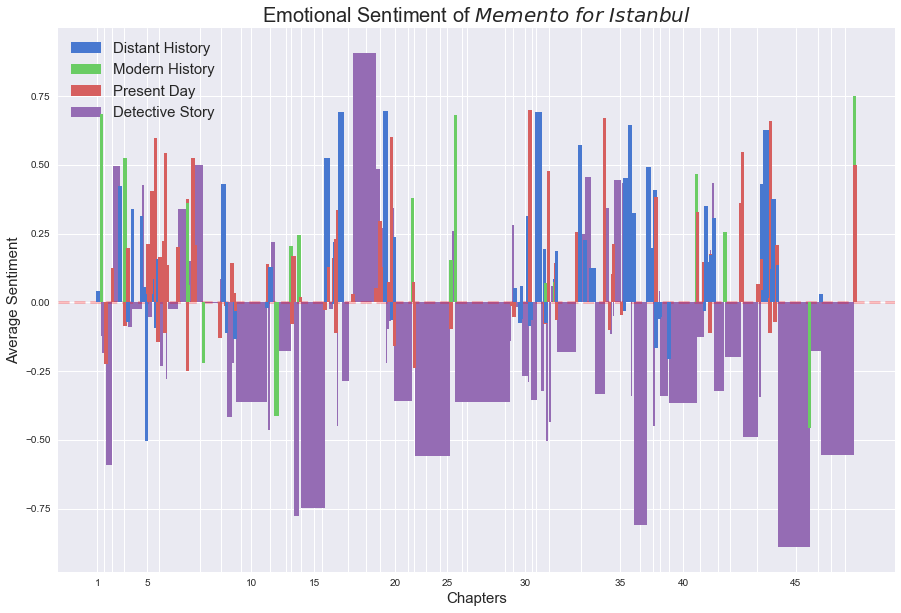

In [16]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Distant History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=50, zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=50, zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=50, zorder=10)
    elif book_indices[section][2] == 'Detective Story':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#956cb4', width=1, zorder=1)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[3], handles[2], handles[1]]
labels = [labels[0], labels[3], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

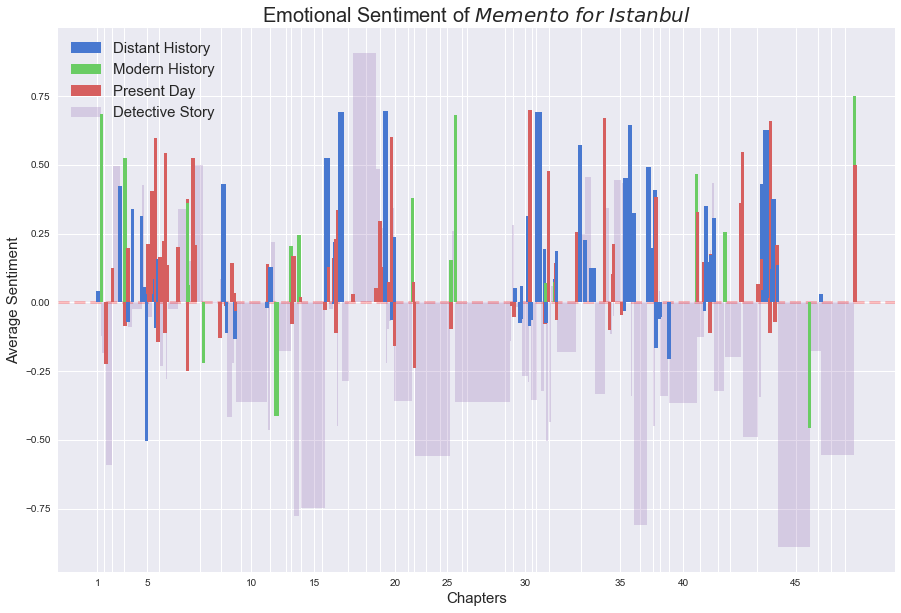

In [17]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Distant History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=50, zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=50, zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=50, zorder=10)
    elif book_indices[section][2] == 'Detective Story':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#956cb4', width=1, zorder=1, alpha=.25)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[3], handles[2], handles[1]]
labels = [labels[0], labels[3], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

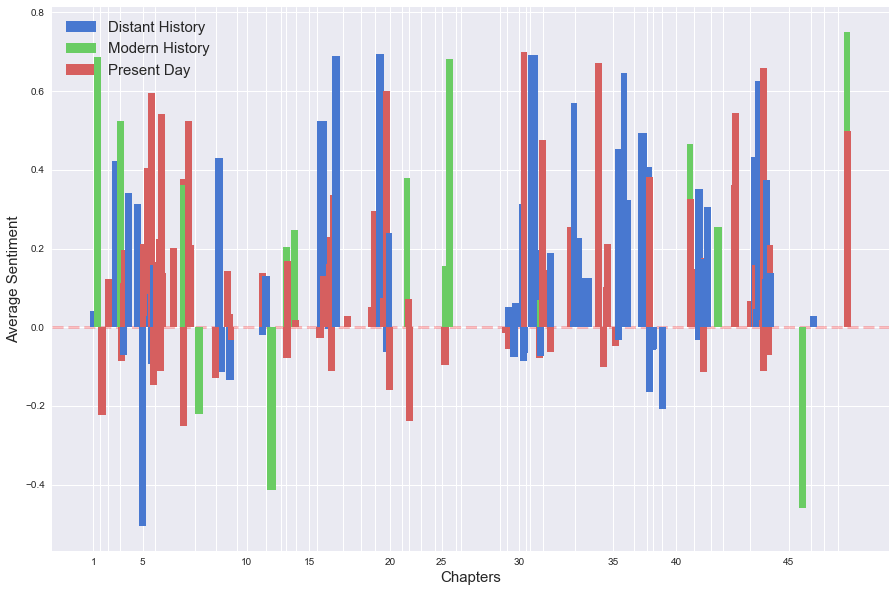

In [18]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Distant History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=100, zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=100, zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=100, zorder=10)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
# plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

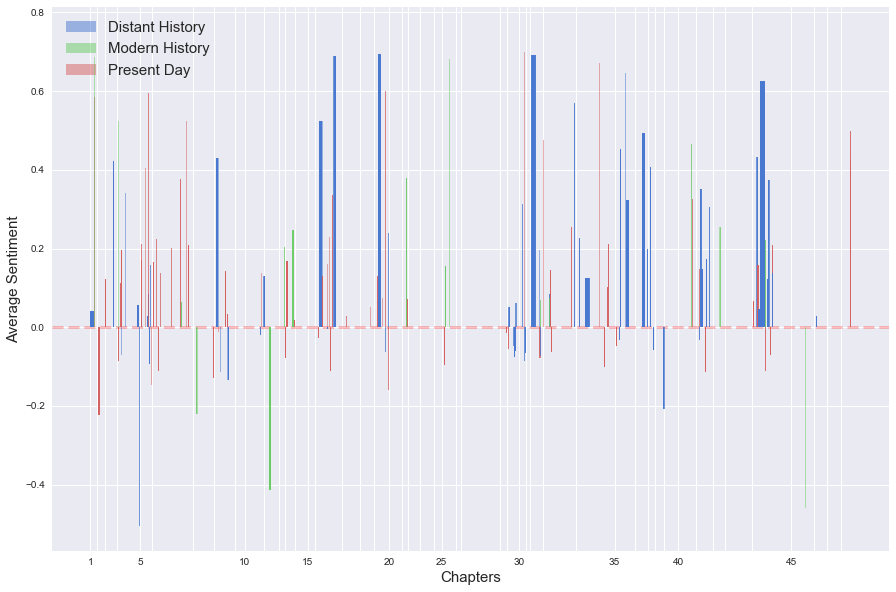

In [19]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Distant History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#4878d0', width=10, zorder=10, alpha=.5)
    elif book_indices[section][2] == 'Modern History':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#6acc64', width=10, zorder=10, alpha=.5)
    elif book_indices[section][2] == 'Present Day':
        plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                 y[book_indices[section][0]: book_indices[section][1]],
                 label=book_indices[section][2], color='#d65f5f', width=10, zorder=10, alpha=.5)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]
plt.legend(handles, labels, loc='upper left', fontsize=15)
# plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

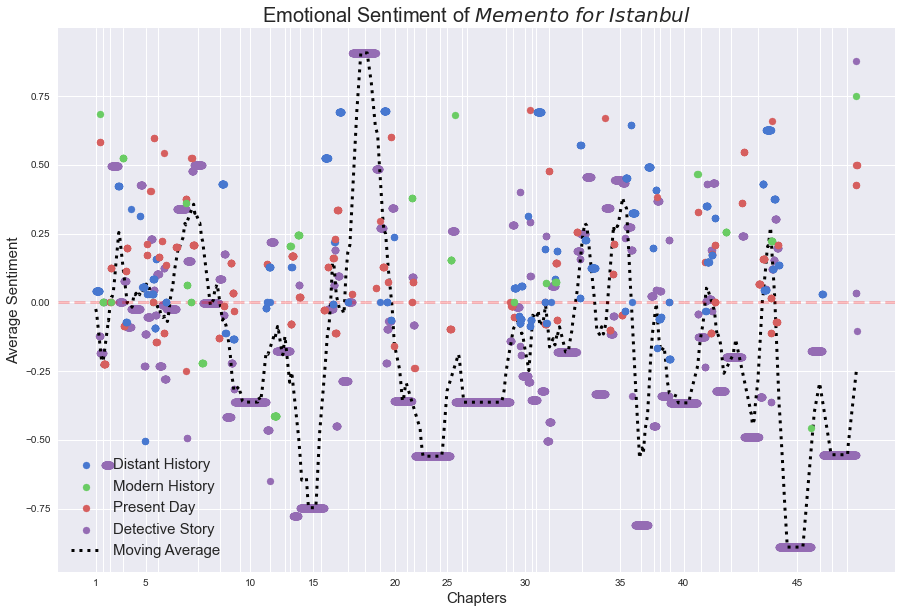

In [20]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

legend_items = {'Distant History': False, 'Modern History': False, 'Present Day': False, 'Detective Story': False}

plt.figure(figsize=(15, 10))

# for chapter in chapter_breaks:
#     plt.axvline(x=chapter, ymin=0.01, ymax=.125, alpha=.5, color='k', linestyle='-', linewidth=1, zorder=1)

for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True

    if book_indices[section][2] == 'Distant History':
        color = '#4878d0'
        zorder=10
    elif book_indices[section][2] == 'Modern History':
        color = '#6acc64'
        zorder=10
    elif book_indices[section][2] == 'Present Day':
        color = '#d65f5f'
        zorder=10
    elif book_indices[section][2] == 'Detective Story':
        color = '#956cb4'
        zorder=1
    plt.scatter(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, color=color, zorder=zorder)
plt.plot(movingaverage(y, 250), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[4], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[4], labels[3], labels[2], labels[0]]
plt.legend(handles, labels, loc='lower left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

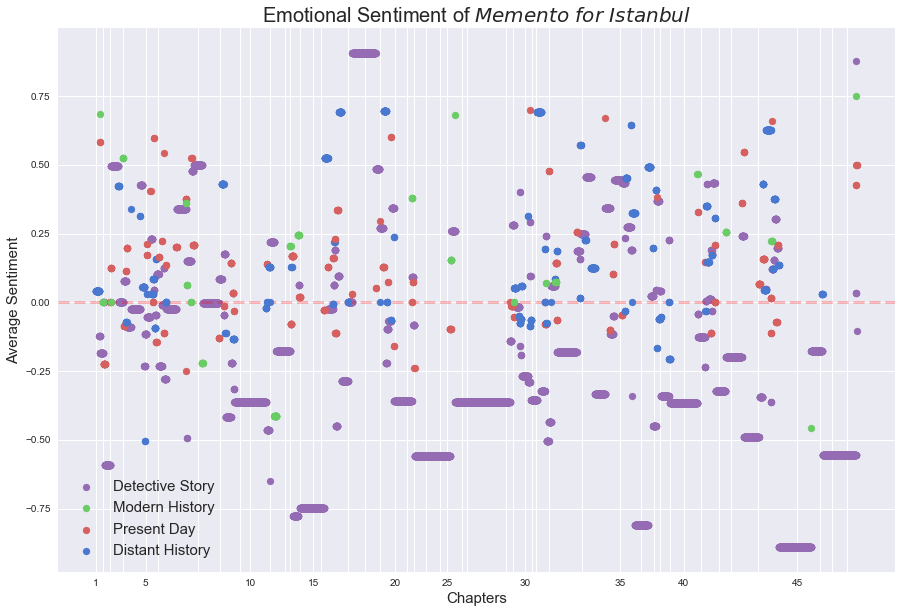

In [21]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

legend_items = {'Distant History': False, 'Modern History': False, 'Present Day': False, 'Detective Story': False}

plt.figure(figsize=(15, 10))

# for chapter in chapter_breaks:
#     plt.axvline(x=chapter, ymin=0.01, ymax=.125, alpha=.5, color='k', linestyle='-', linewidth=1, zorder=1)

for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True

    if book_indices[section][2] == 'Distant History':
        color = '#4878d0'
        zorder=10
    elif book_indices[section][2] == 'Modern History':
        color = '#6acc64'
        zorder=10
    elif book_indices[section][2] == 'Present Day':
        color = '#d65f5f'
        zorder=10
    elif book_indices[section][2] == 'Detective Story':
        color = '#956cb4'
        zorder=1
    plt.scatter(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, color=color, zorder=zorder)
# plt.plot(movingaverage(y, 250), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[3], labels[2], labels[0]]
plt.legend(handles, labels, loc='lower left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

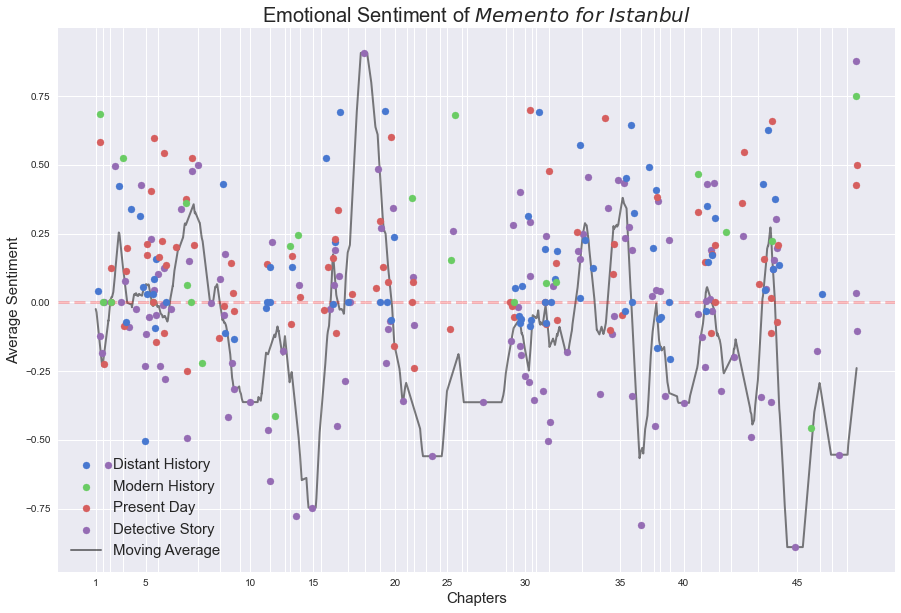

In [22]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)
x = np.linspace(0, length, num=length+1)
y = [item for sublist in [[section[4]['compound']] * section[3] for section in novel] for item in sublist]

plt.figure(figsize=(15, 10))

for section in book_indices:
    if book_indices[section][2] == 'Distant History':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#4878d0', zorder=10)
    elif book_indices[section][2] == 'Modern History':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#6acc64', zorder=10)
    elif book_indices[section][2] == 'Present Day':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#d65f5f', zorder=10)
    elif book_indices[section][2] == 'Detective Story':
        plt.scatter((x[book_indices[section][0]] + x[book_indices[section][1]]) / 2,
                 y[book_indices[section][0]],
                 label=book_indices[section][2], color='#956cb4', zorder=5)
plt.plot(movingaverage(y, 250), color='k', alpha=.5, linewidth=2, linestyle='-', label = 'Moving Average', zorder=1)
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[4], handles[3], handles[2], handles[0]]
labels = [labels[1], labels[4], labels[3], labels[2], labels[0]]
plt.legend(handles, labels, loc='lower left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

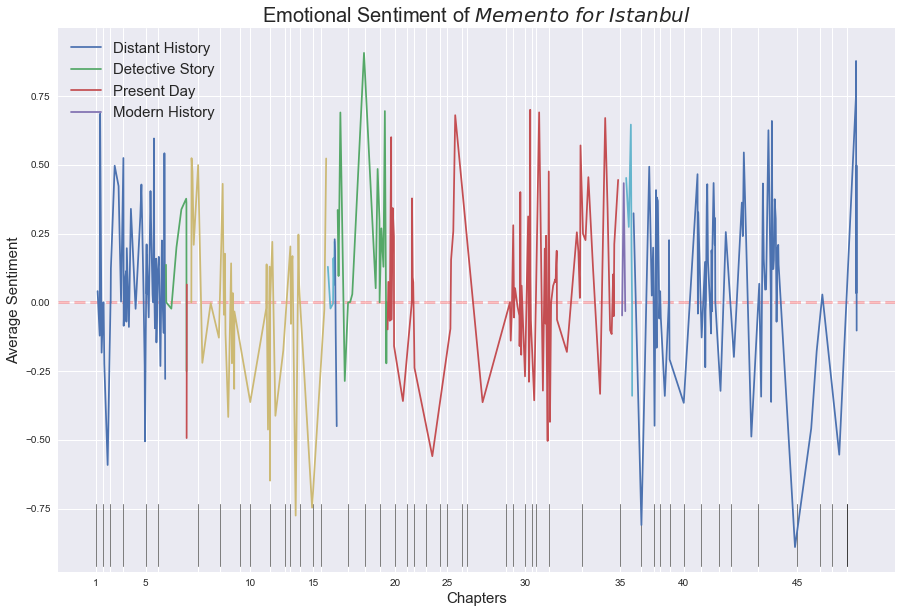

In [23]:
length = sum([section[3] for section in novel])

x = []
previous = 0
for idx, element in enumerate([section[3] for section in novel]):
    if idx == 0:
        x.append(element / 2)
    else:
        x.append(previous + element / 2)
    previous += element
    
y = [item for sublist in [[section[4]['compound']] for section in novel] for item in sublist]

legend_items = {'Distant History': False, 'Modern History': False, 'Present Day': False, 'Detective Story': False}

plt.figure(figsize=(15, 10))

for chapter in chapter_breaks:
    plt.axvline(x=chapter, ymin=0.01, ymax=.125, alpha=.5, color='k', linestyle='-', linewidth=1, zorder=1)

for section in book_indices:
    if legend_items[book_indices[section][2]]:
        label = ''
    else:
        label = book_indices[section][2]
        legend_items[book_indices[section][2]] = True
    plt.plot(x[book_indices[section][0]: book_indices[section][1]],
             y[book_indices[section][0]: book_indices[section][1]],
             label=label, zorder=10)
# plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
plt.legend(loc='upper left', fontsize=15)
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xlabel('Chapters', fontsize=15)
plt.xticks(ticks=chapter_breaks, labels=[chapter + 1 if chapter == 0 or (chapter + 1) % 5 == 0 else '' for chapter in range(len(chapter_breaks))])
plt.ylabel('Average Sentiment', fontsize=15)
plt.show()

In [24]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('NRC-Sentiment-Emotion-Lexicons/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t').dropna()
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    
    for i, row in new_df.iterrows():
        document = word_tokenize(new_df.loc[i][column])
        for word in document:
            word = stemmer.stem(word.lower())
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [25]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465


In [26]:
from collections import Counter

def text_emotion_with_counter(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    new_df = df.copy()

    filepath = ('NRC-Sentiment-Emotion-Lexicons/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t').dropna()
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    
    emotion_count = {}
    for emotion in emotions:
        emotion_count[emotion] = Counter()
    
    for i, row in new_df.iterrows():
        document = word_tokenize(new_df.loc[i][column])
        for word in document:
            word = stemmer.stem(word.lower())
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df.at[i, emotion] += emo_score[emotion]
                    if emo_score[emotion].values == 1:
                        emotion_count[emotion][word] += 1

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df, emotion_count

In [27]:
# df = text_emotion(df, 'text')
df, emotion_count = text_emotion_with_counter(df, 'text')
df['word_count'] = df['text'].apply(tokenize.word_tokenize).apply(len)
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']
for emotion in emotions:
    df[emotion] = df[emotion] / df['word_count']

In [28]:
for emotion in emotions:
    print(emotion, emotion_count[emotion].most_common(10))

anger [('victim', 198), ('murder', 152), ('death', 85), ('lie', 71), ('stone', 69), ('tree', 46), ('lawyer', 43), ('fear', 42), ('gun', 40), ('hell', 37)]
anticipation [('time', 331), ('good', 163), ('thought', 163), ('start', 156), ('god', 133), ('happen', 115), ('wait', 111), ('long', 110), ('young', 88), ('death', 85)]
disgust [('murder', 152), ('death', 85), ('lie', 71), ('tree', 46), ('boy', 43), ('lawyer', 43), ('hell', 37), ('smell', 31), ('lose', 30), ('parrot', 25)]
fear [('sultan', 224), ('kill', 212), ('victim', 198), ('murder', 152), ('god', 133), ('death', 85), ('case', 84), ('watch', 80), ('doubt', 63), ('die', 60)]
joy [('found', 195), ('good', 163), ('love', 156), ('god', 133), ('friend', 131), ('smile', 117), ('kind', 111), ('young', 88), ('hope', 76), ('church', 72)]
negative [('kill', 212), ('victim', 198), ('murder', 152), ('wait', 111), ('death', 85), ('case', 84), ('quit', 75), ('lost', 74), ('lie', 71), ('stone', 69)]
positive [('don', 396), ('inspector', 201), (

In [29]:
total_emotion_count = Counter()
for emotion in emotions:
    total_emotion_count += emotion_count[emotion]

In [30]:
from functools import reduce
from operator import add
reduce(add, [emotion_count[emotion] for emotion in emotions]) == total_emotion_count

True

In [31]:
len(total_emotion_count)

1346

In [32]:
total_emotion_count.most_common(10)

[('murder', 912),
 ('good', 815),
 ('victim', 792),
 ('don', 792),
 ('god', 665),
 ('kill', 636),
 ('death', 595),
 ('found', 585),
 ('smile', 468),
 ('friend', 393)]

In [33]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentence = 'Again, human interaction needs to have resolutions. Your reps cannot BLAME the system and shrug off being able to help. Let alone blame the system and not know WHY the system makes indiscriminate decisions.'
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sid.polarity_scores(word)['compound']) >= 0.1:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.1:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)                

print('Positive:',pos_word_list)        
print('Neutral:',neu_word_list)    
print('Negative:',neg_word_list) 
score = sid.polarity_scores(sentence)
print('\nScores:', score)

Positive: ['help']
Neutral: ['Again', ',', 'human', 'interaction', 'needs', 'to', 'have', 'resolutions', '.', 'Your', 'reps', 'can', 'not', 'the', 'system', 'and', 'shrug', 'off', 'being', 'able', 'to', '.', 'Let', 'the', 'system', 'and', 'not', 'know', 'WHY', 'the', 'system', 'makes', 'indiscriminate', 'decisions', '.']
Negative: ['BLAME', 'alone', 'blame']

Scores: {'neg': 0.111, 'neu': 0.756, 'pos': 0.133, 'compound': 0.2212}


In [34]:
import string

sentiment_count = {}
sid = SentimentIntensityAnalyzer()

for sentiment in ['positive', 'neutral', 'negative']:
    sentiment_count[sentiment] = Counter()

for i, row in df.iterrows():
    tokenized_sentence = nltk.word_tokenize(row['text'].translate(str.maketrans('', '', string.punctuation + '’' + '“' + '”')))
    
    for word in tokenized_sentence:
        if (sid.polarity_scores(word)['compound']) >= 0.1:
            sentiment_count['positive'][word] += 1
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            sentiment_count['negative'][word] += 1
        else:
            sentiment_count['neutral'][word] += 1

In [35]:
for sentiment in ['positive', 'neutral', 'negative']:
    print(sentiment, sentiment_count[sentiment].most_common(10))

positive [('like', 468), ('well', 164), ('good', 129), ('hand', 126), ('sure', 110), ('Well', 109), ('God', 101), ('kind', 96), ('help', 83), ('straight', 77)]
neutral [('the', 10673), ('to', 5167), ('and', 4218), ('I', 4111), ('of', 4105), ('was', 3472), ('a', 3367), ('in', 2597), ('he', 1582), ('you', 1555)]
negative [('no', 401), ('No', 131), ('victims', 122), ('killed', 114), ('killers', 102), ('Ill', 97), ('killer', 90), ('victim', 80), ('death', 76), ('lost', 72)]


In [36]:
sentiment_count = {}
sid = SentimentIntensityAnalyzer()
stemmer = SnowballStemmer("english")

for sentiment in ['positive', 'neutral', 'negative']:
    sentiment_count[sentiment] = Counter()

for i, row in df.iterrows():
    tokenized_sentence = nltk.word_tokenize(row['text'].translate(str.maketrans('', '', string.punctuation + '’' + '“' + '”')))
    stemmed_sentence = [stemmer.stem(word.lower()) for word in tokenized_sentence]
    
    for word in stemmed_sentence:
        if (sid.polarity_scores(word)['compound']) >= 0.1:
            sentiment_count['positive'][word] += 1
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            sentiment_count['negative'][word] += 1
        else:
            sentiment_count['neutral'][word] += 1

In [37]:
for sentiment in ['positive', 'neutral', 'negative']:
    print(sentiment, sentiment_count[sentiment].most_common(10))

positive [('like', 525), ('hand', 290), ('well', 276), ('good', 164), ('love', 156), ('friend', 138), ('god', 134), ('smile', 119), ('sure', 117), ('yes', 117)]
neutral [('the', 11822), ('to', 5238), ('and', 4584), ('of', 4208), ('i', 4111), ('a', 3551), ('was', 3539), ('in', 2731), ('it', 2533), ('he', 2424)]
negative [('no', 532), ('kill', 218), ('victim', 202), ('killer', 196), ('murder', 160), ('stop', 109), ('ill', 104), ('death', 92), ('miss', 86), ('poor', 80)]


In [38]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527,0.017586,0.023981,0.007194,0.018385,0.015987,0.035971,0.068745,0.017586,0.007994,0.019984,1251
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750,0.021164,0.026455,0.010582,0.021164,0.005291,0.026455,0.037037,0.015873,0.010582,0.021164,189
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500,0.030303,0.030303,0.015152,0.015152,0.030303,0.015152,0.075758,0.015152,0.030303,0.045455,66
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000,0.000000,0.019231,0.000000,0.000000,0.038462,0.019231,0.038462,0.019231,0.019231,0.019231,52
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465,0.008761,0.012516,0.001252,0.015019,0.003755,0.030038,0.013767,0.013767,0.002503,0.008761,799


In [39]:
df.columns

Index(['section', 'period', 'text', 'sentence_count', 'compound', 'pos', 'neg',
       'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust', 'word_count'],
      dtype='object')

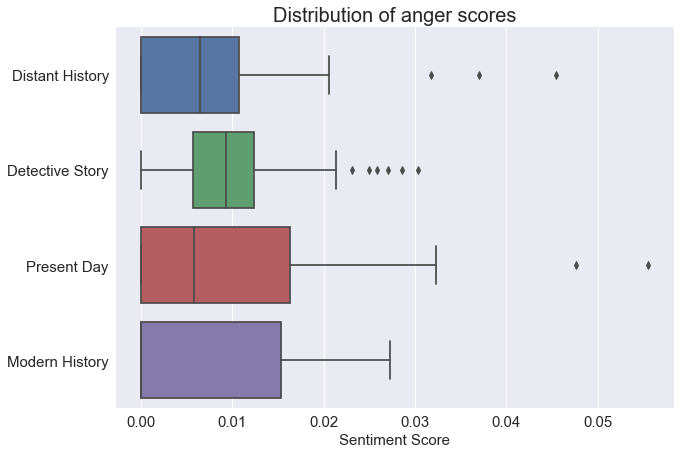

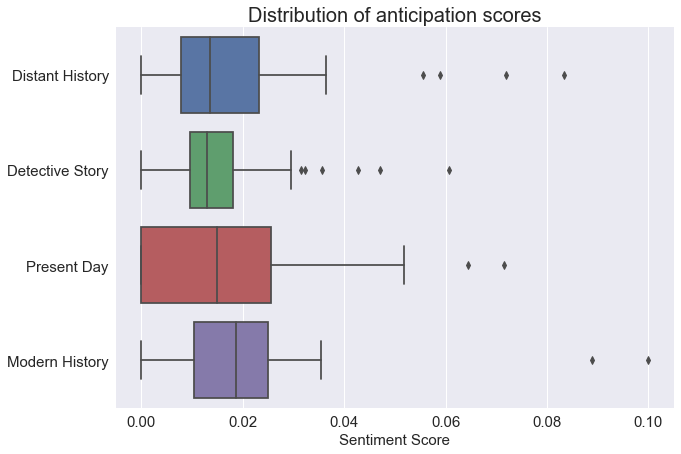

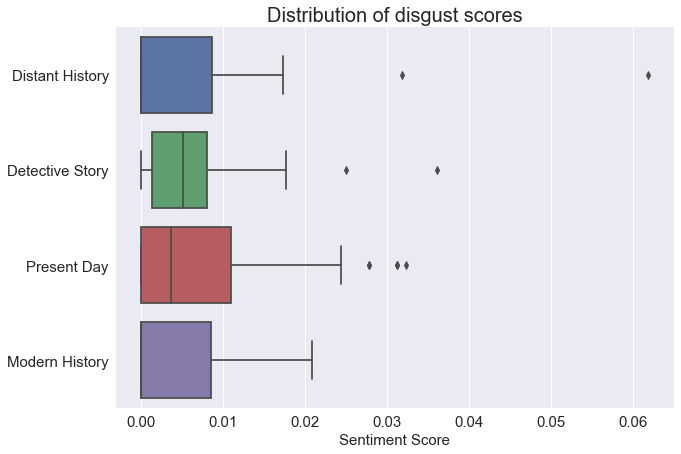

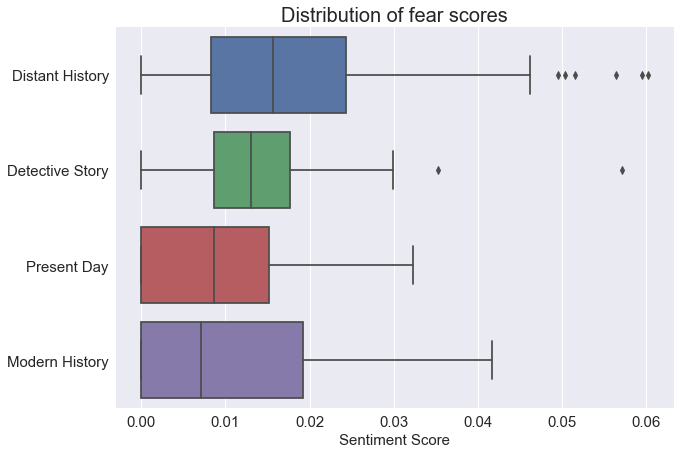

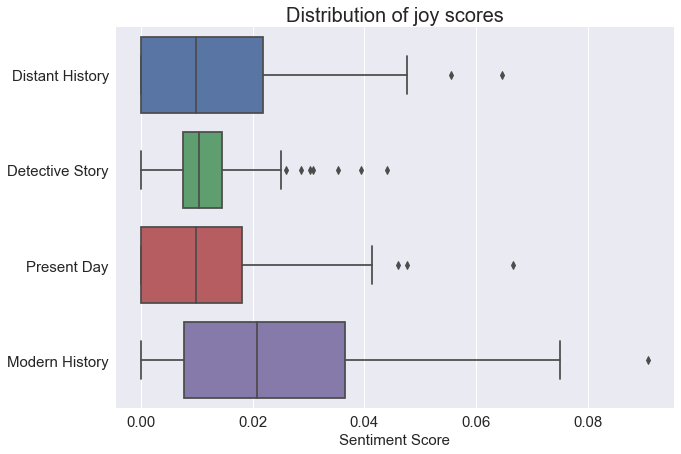

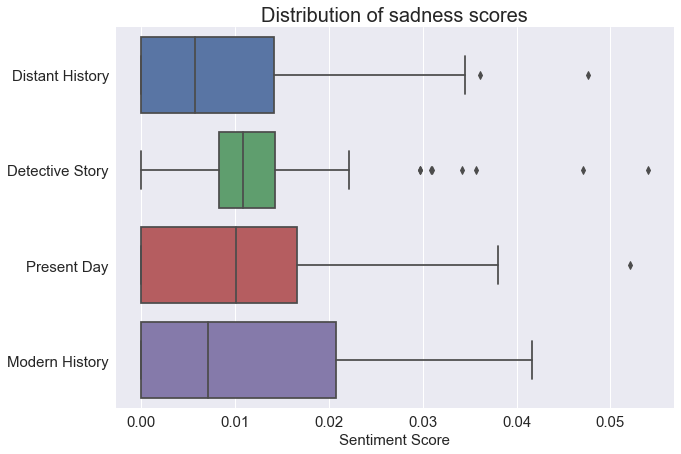

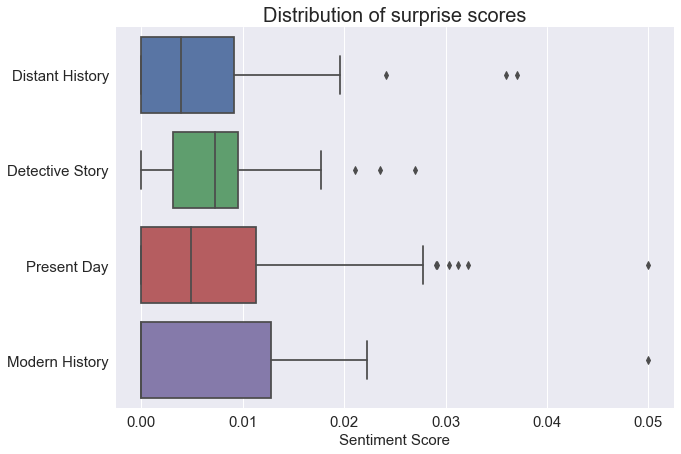

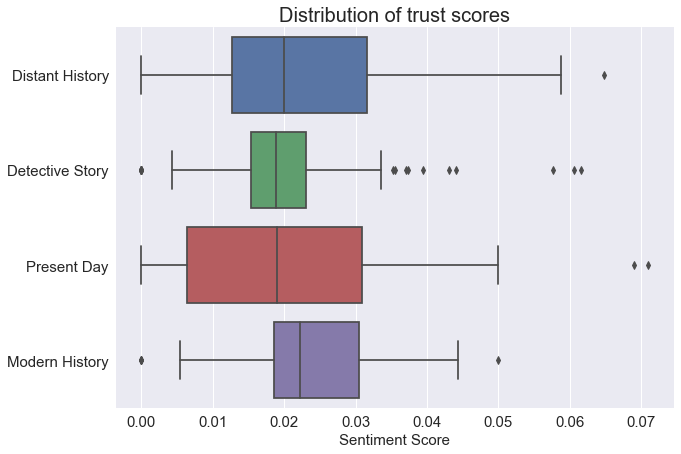

In [40]:
for col in ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']:
    plt.figure(figsize=(10, 7))
    sns.boxplot(x=col, y='period', data=df, notch=False)
    plt.xlabel('Sentiment Score', fontsize=15)
    plt.ylabel('')
    plt.title('Distribution of {} scores'.format(col), fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # plt.savefig(boxplot.jpg, dpi=300)
    plt.show()

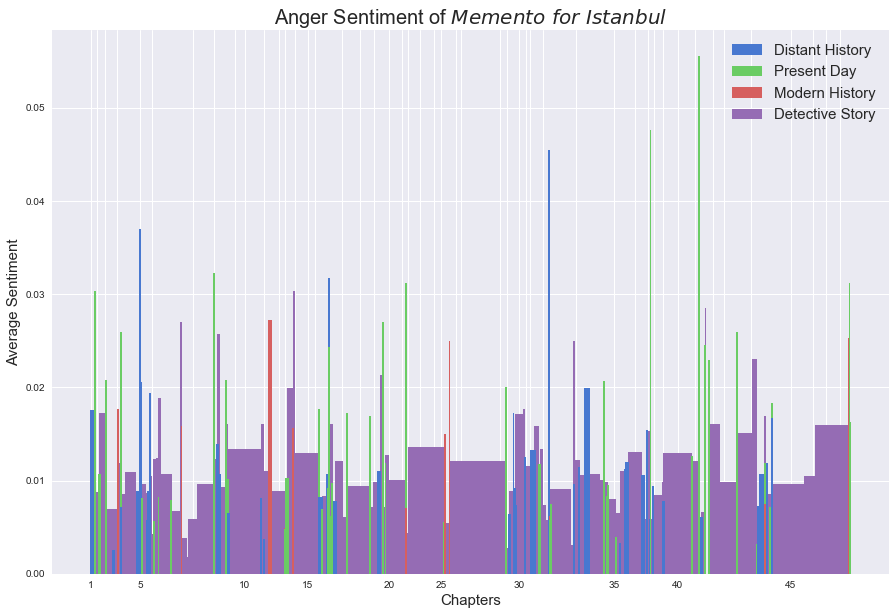

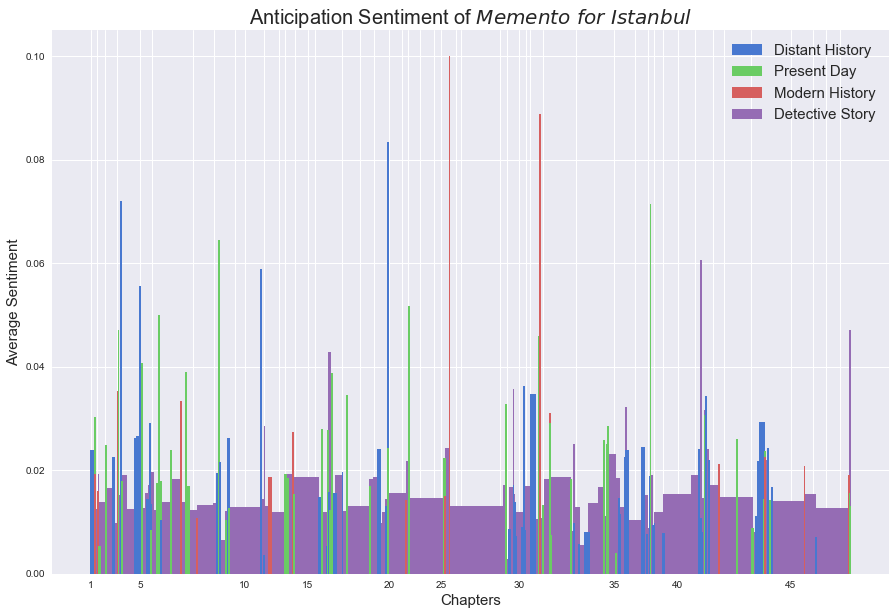

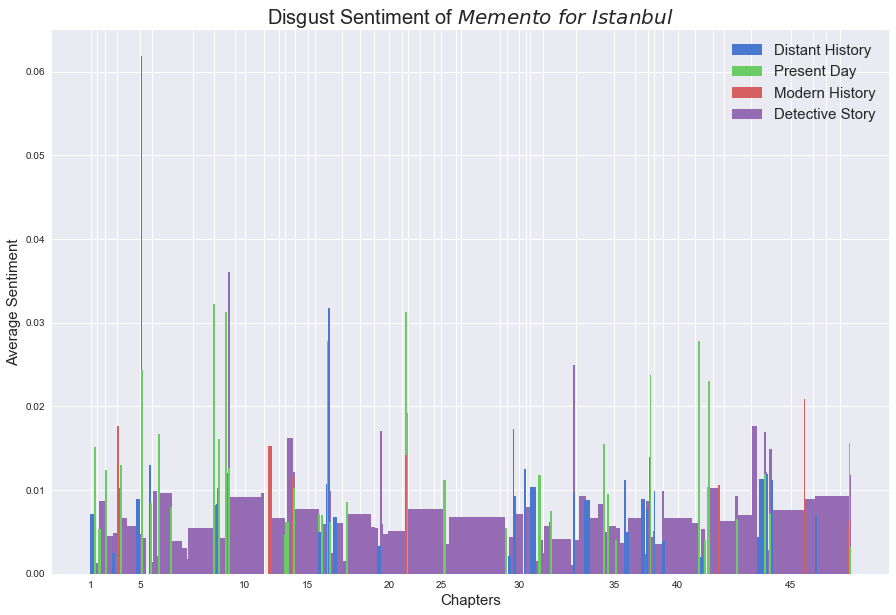

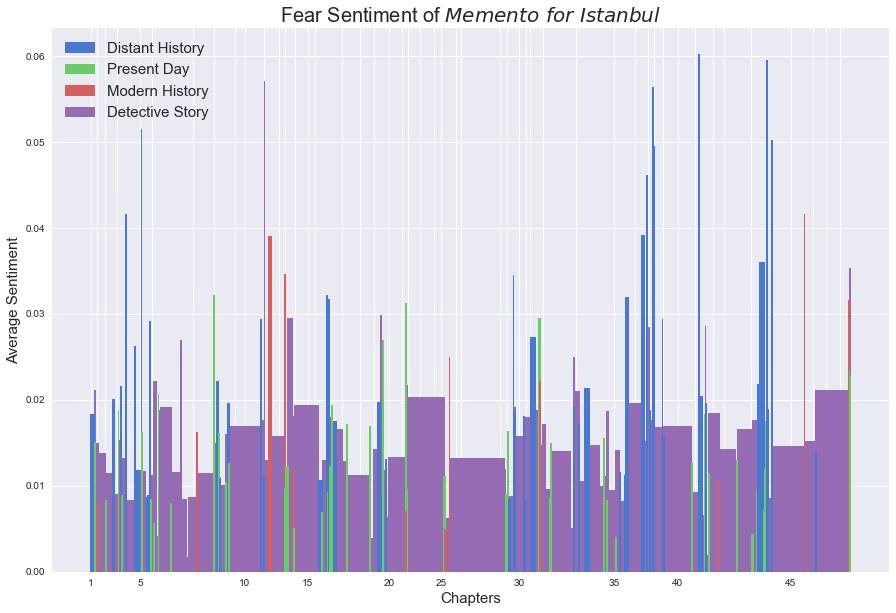

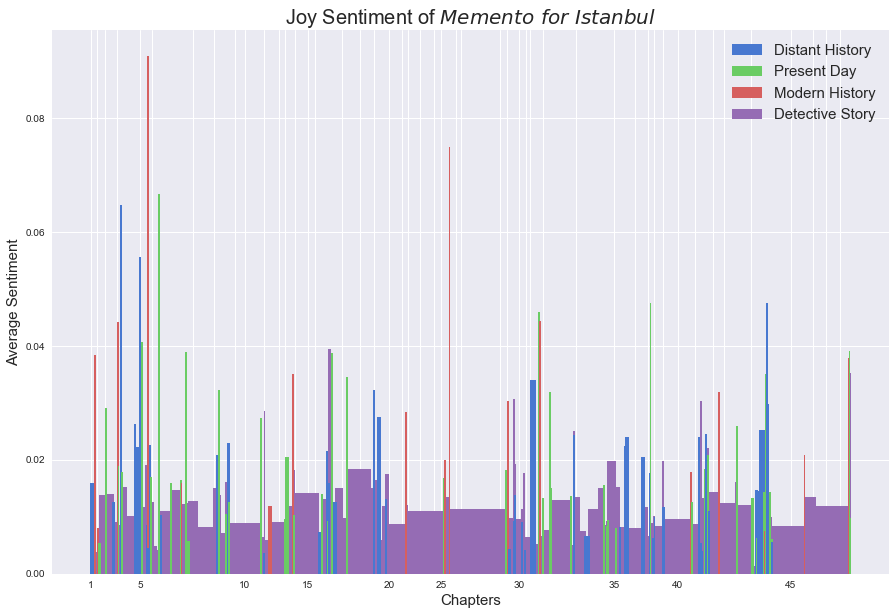

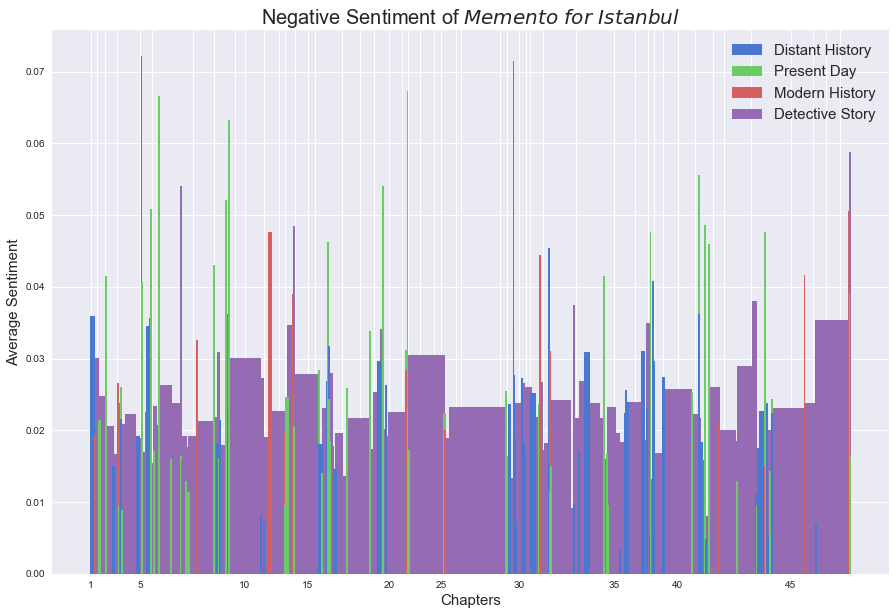

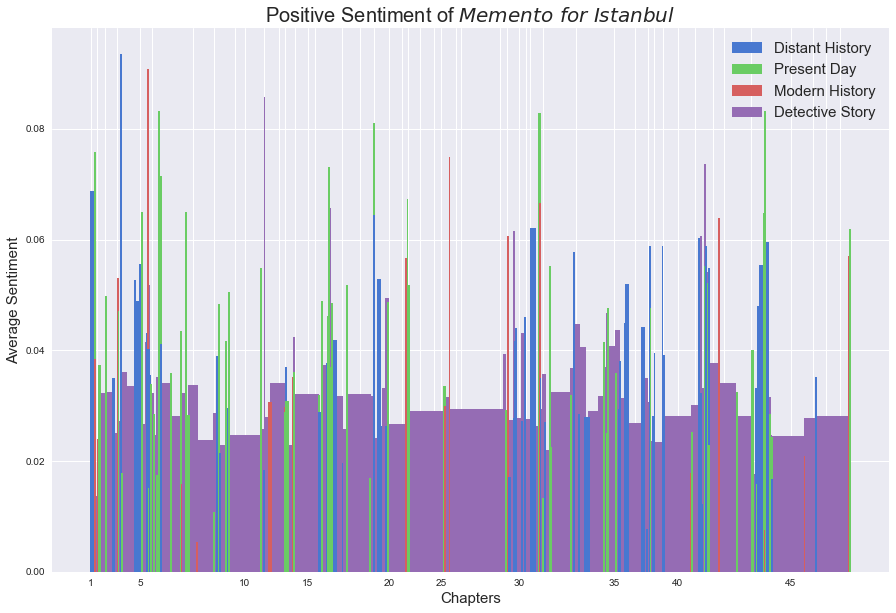

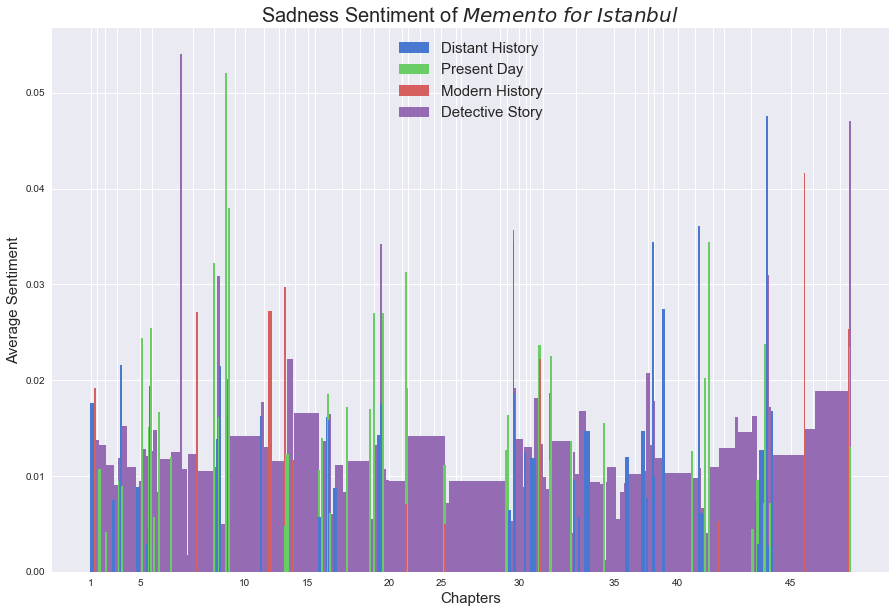

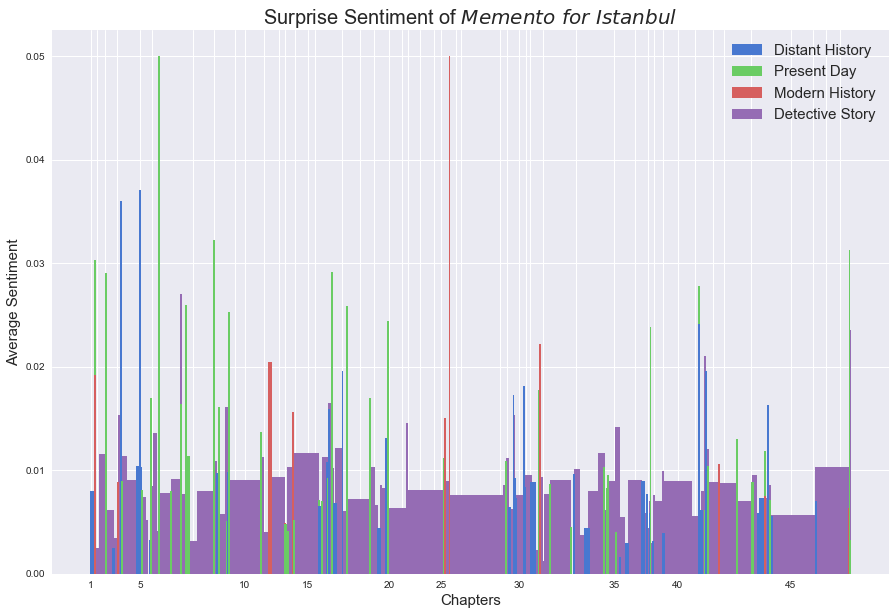

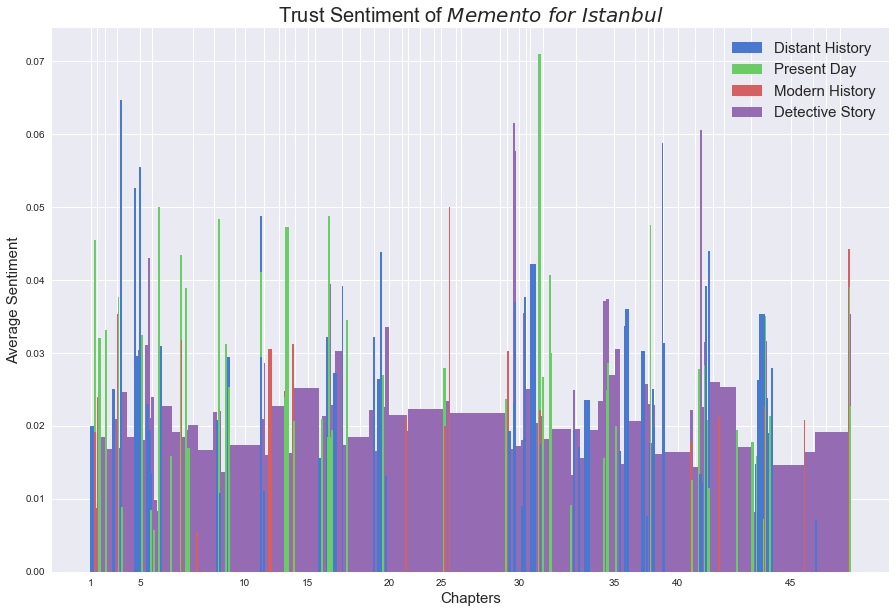

In [41]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [item for sublist in [[row[emotion]] * row['sentence_count'] for idx, row in df.iterrows()] for item in sublist]

    plt.figure(figsize=(15, 10))
    for section in book_indices:
        if book_indices[section][2] == 'Distant History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#4878d0', width=25, zorder=10)
        elif book_indices[section][2] == 'Modern History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#d65f5f', width=25, zorder=10)
        elif book_indices[section][2] == 'Present Day':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#6acc64', width=25, zorder=10)
        elif book_indices[section][2] == 'Detective Story':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#956cb4', width=25, zorder=1)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [handles[0], handles[2], handles[3], handles[1]]
    labels = [labels[0], labels[2], labels[3], labels[1]]
    plt.legend(handles, labels, loc='best', fontsize=15)
    plt.title(r'{} Sentiment of $Memento\ for\ Istanbul$'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapters', fontsize=15)
    plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

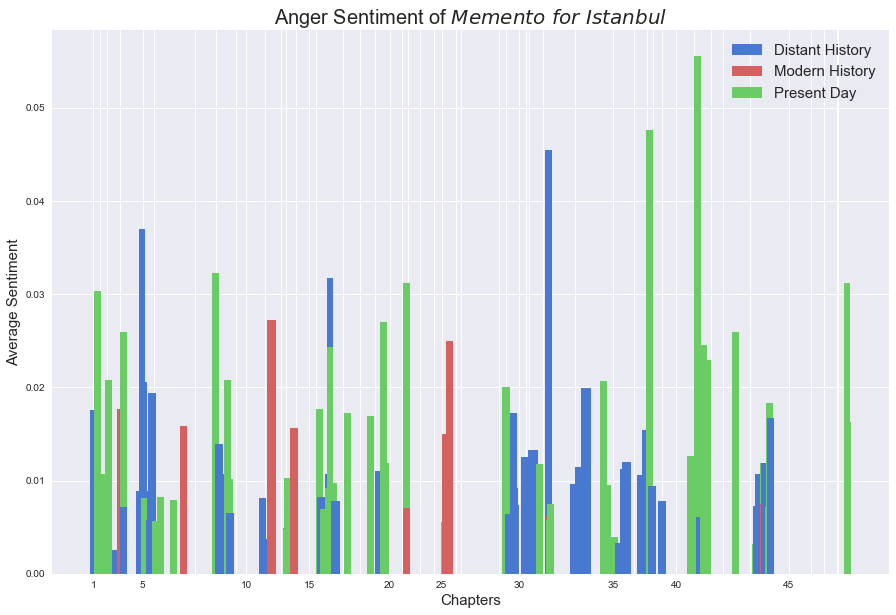

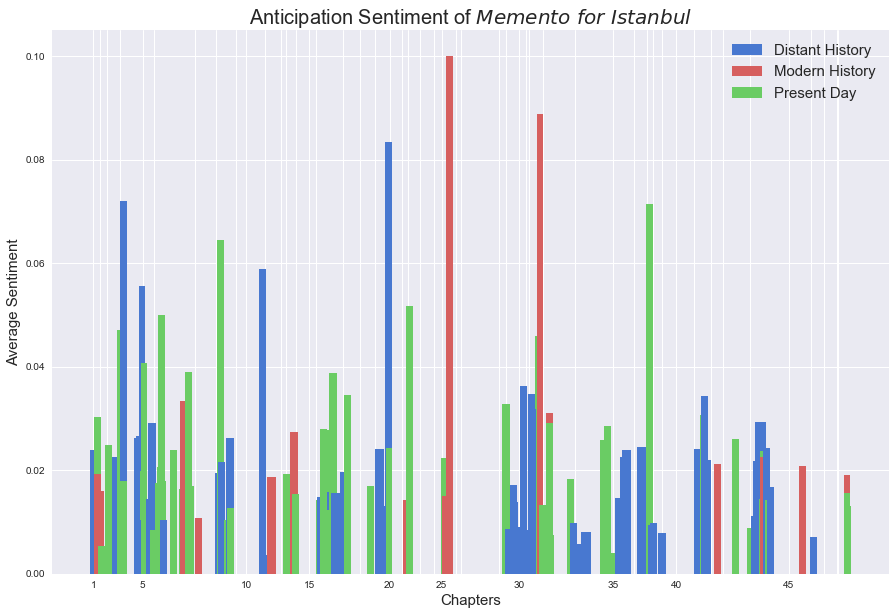

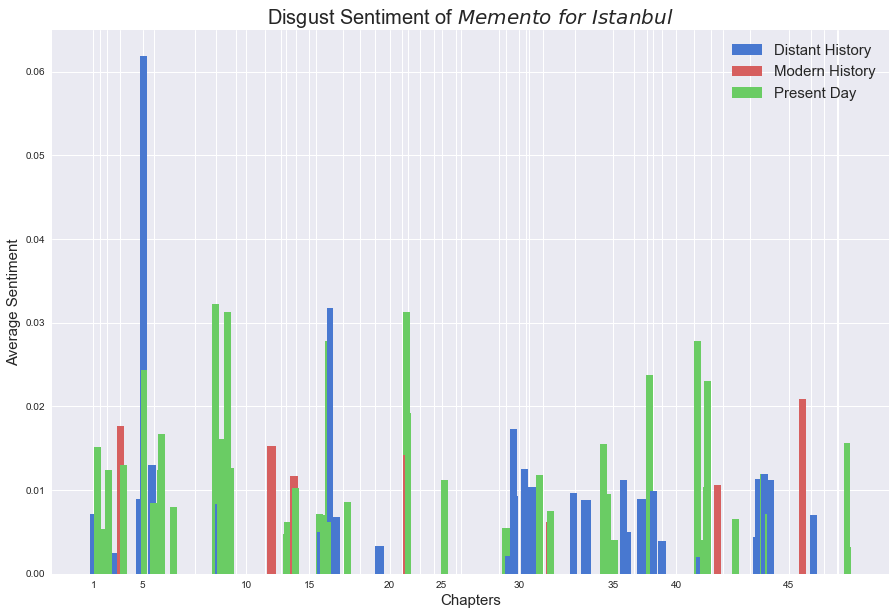

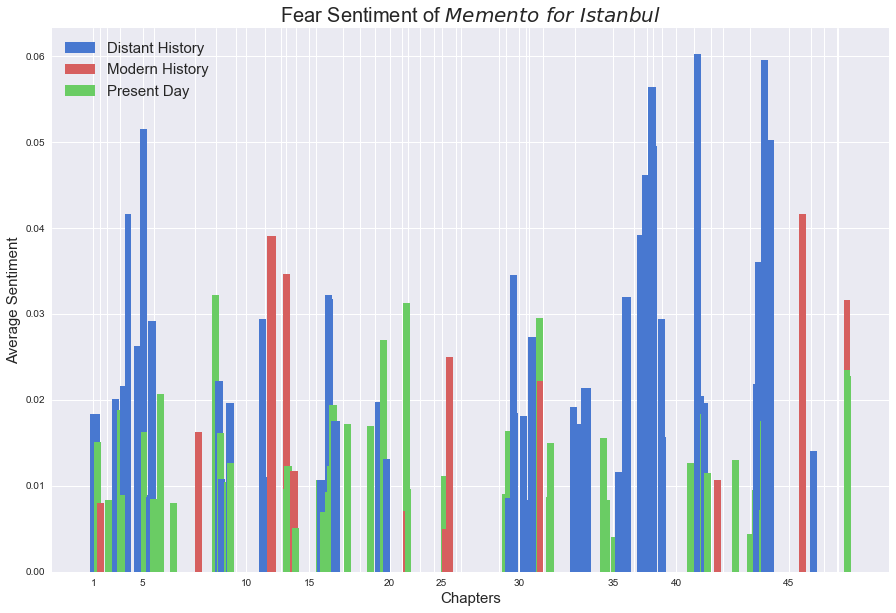

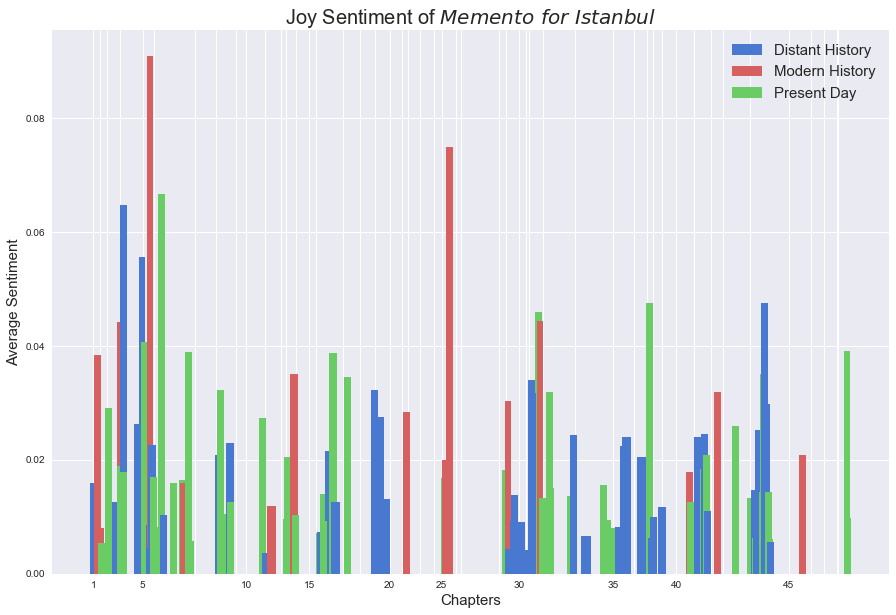

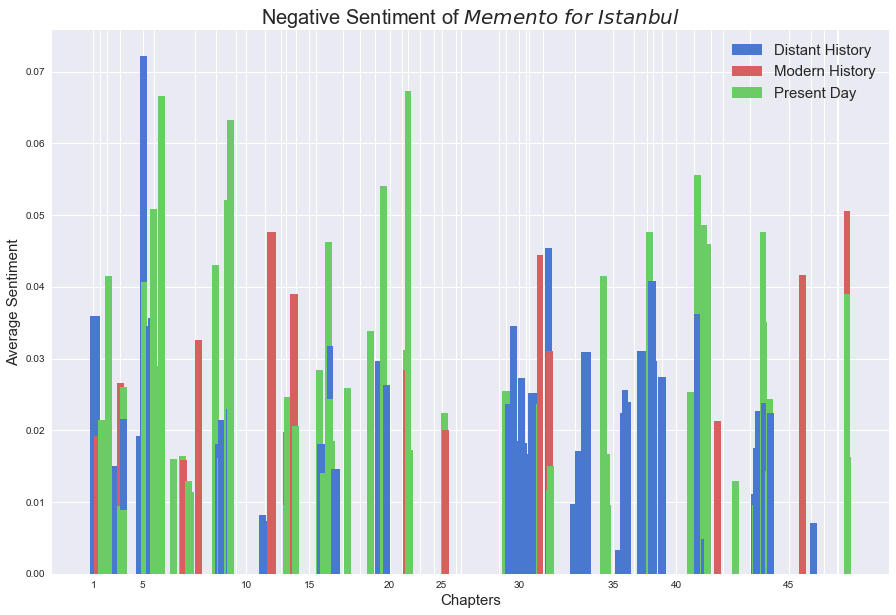

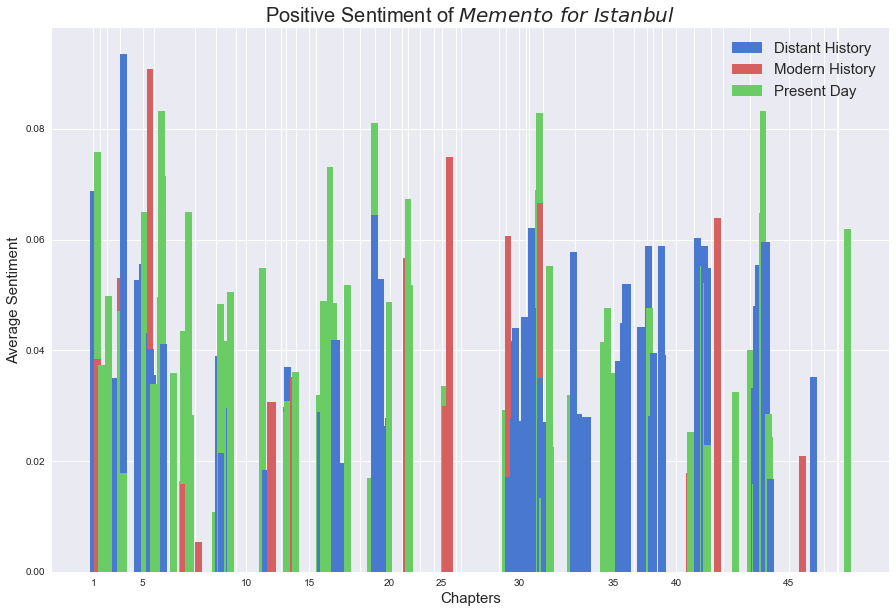

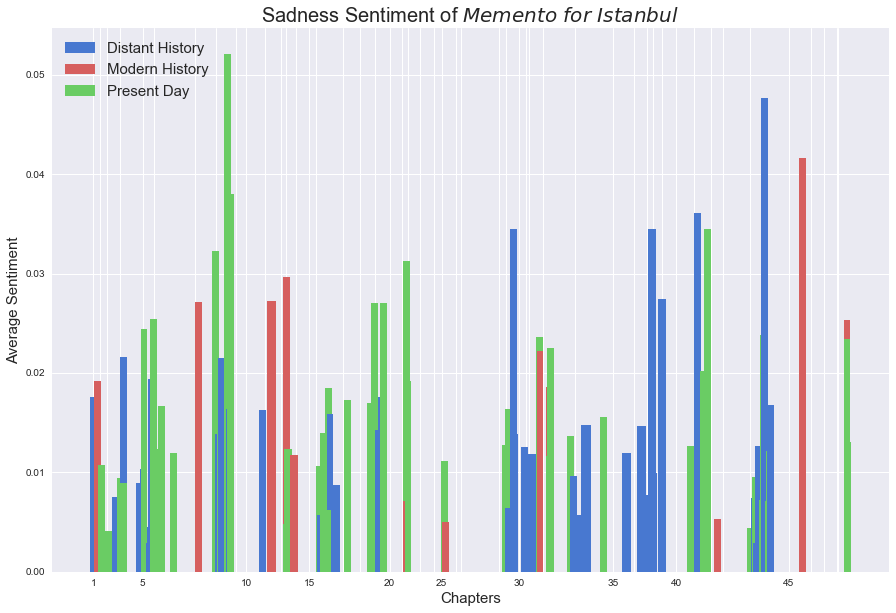

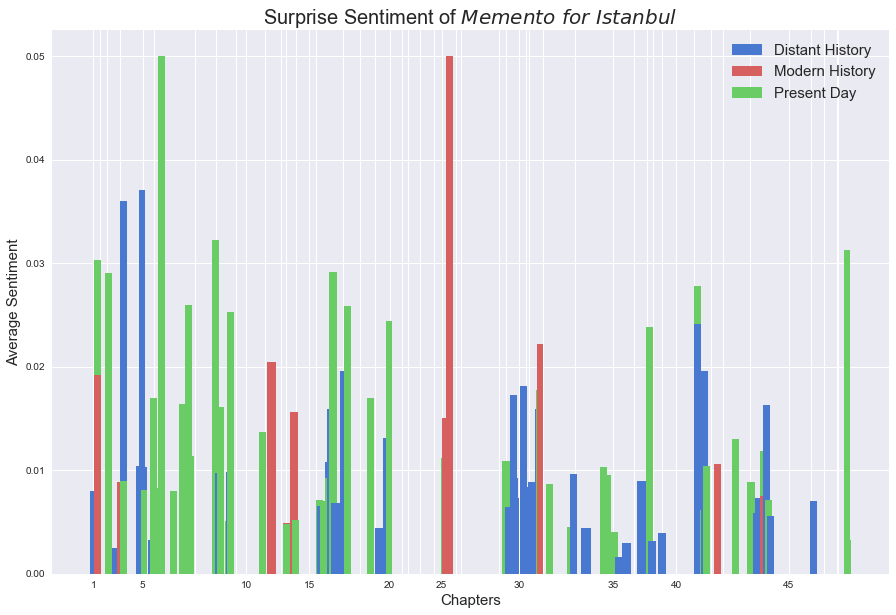

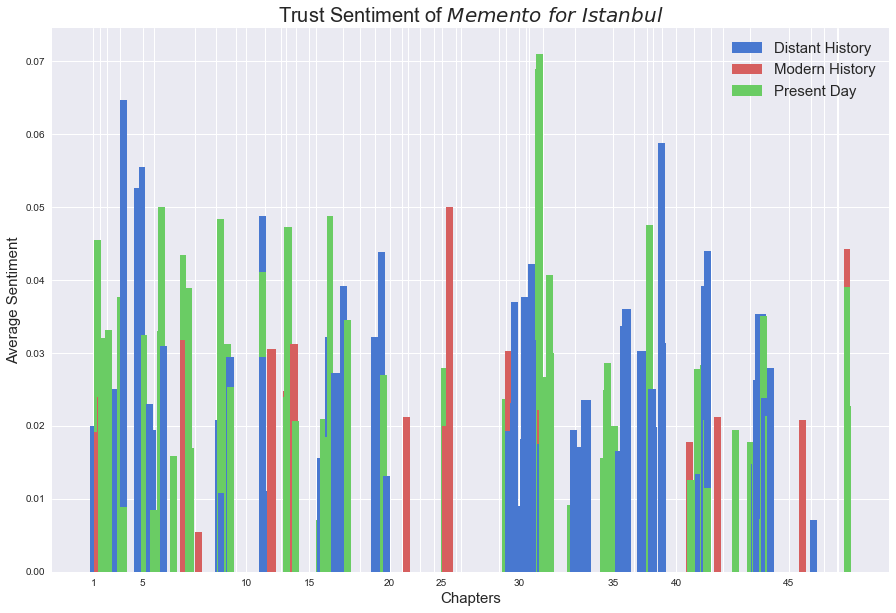

In [42]:
length = sum([section[3] for section in novel])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [item for sublist in [[row[emotion]] * row['sentence_count'] for idx, row in df.iterrows()] for item in sublist]

    plt.figure(figsize=(15, 10))
    for section in book_indices:
        if book_indices[section][2] == 'Distant History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#4878d0', width=100, zorder=10)
        elif book_indices[section][2] == 'Modern History':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#d65f5f', width=100, zorder=10)
        elif book_indices[section][2] == 'Present Day':
            plt.bar(x[book_indices[section][0]: book_indices[section][1]],
                     y[book_indices[section][0]: book_indices[section][1]],
                     label=book_indices[section][2], color='#6acc64', width=100, zorder=10)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [handles[0], handles[2], handles[1]]
    labels = [labels[0], labels[2], labels[1]]
    plt.legend(handles, labels, loc='best', fontsize=15)
    plt.title('{} Sentiment of $Memento\ for\ Istanbul$'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapters', fontsize=15)
    plt.xticks(ticks=chapter_breaks, labels=[element + 1 if element == 0 or (element + 1) % 5 == 0 else '' for element in range(len(chapter_breaks))])
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

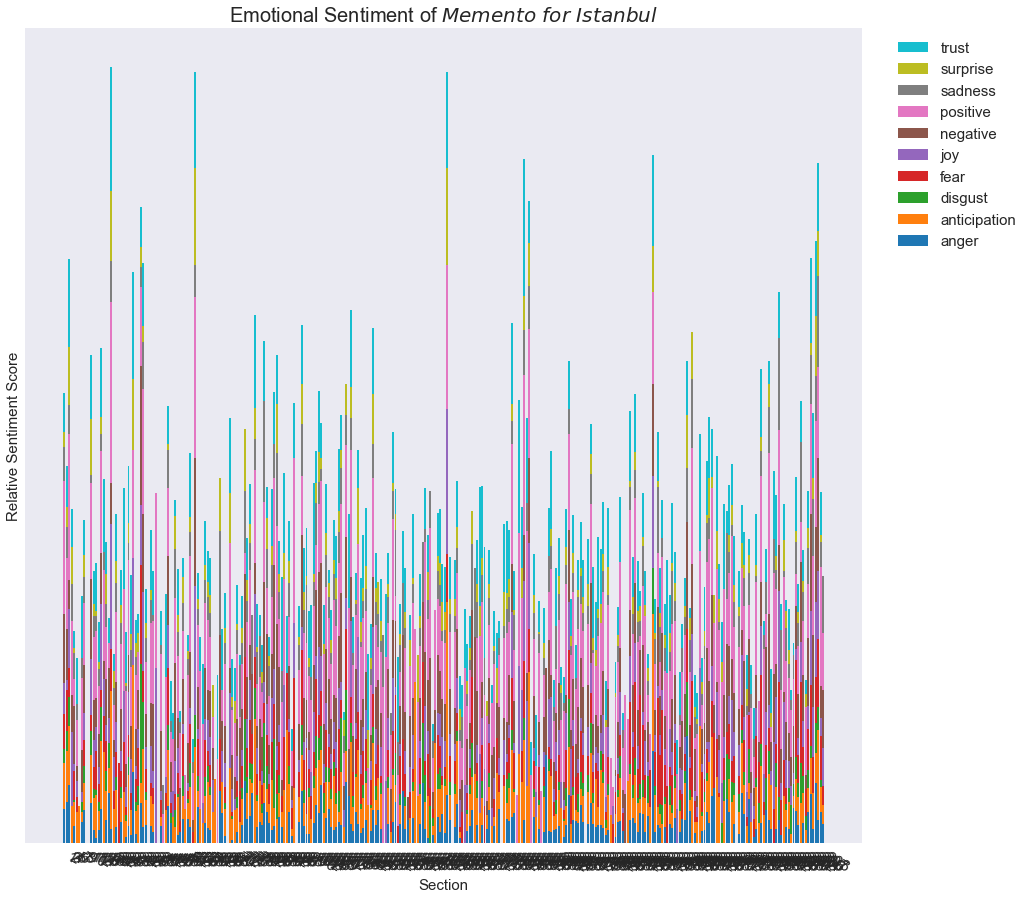

In [43]:
tab10 = matplotlib.cm.get_cmap('tab10')

sections = df['section'].tolist()
margin_bottom = np.zeros(len(sections))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = np.array(df[emotion])
    plt.bar(sections, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(sections, sections, rotation=-30, ha='left', fontsize=15)
plt.xlabel('Section', fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
plt.yticks([])
ax.grid(False)
plt.show()

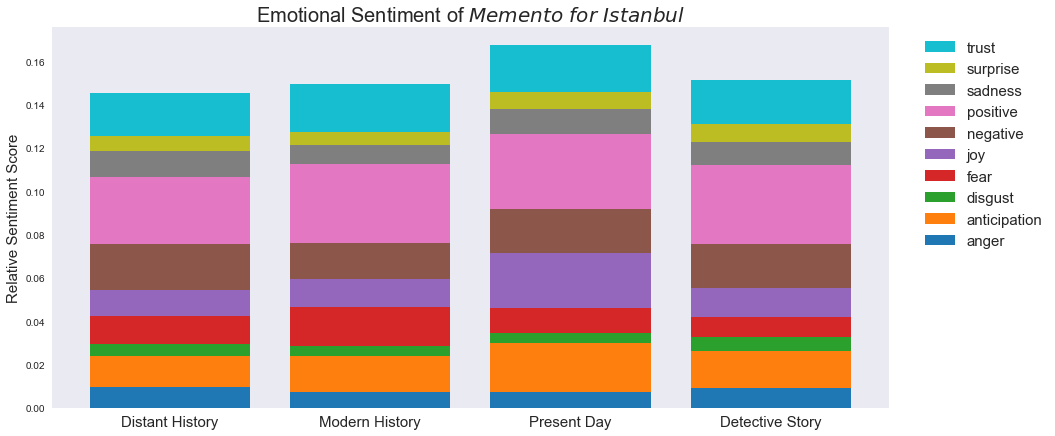

In [44]:
tab10 = matplotlib.cm.get_cmap('tab10')

periods = ['Distant History', 'Modern History', 'Present Day', 'Detective Story']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = df.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

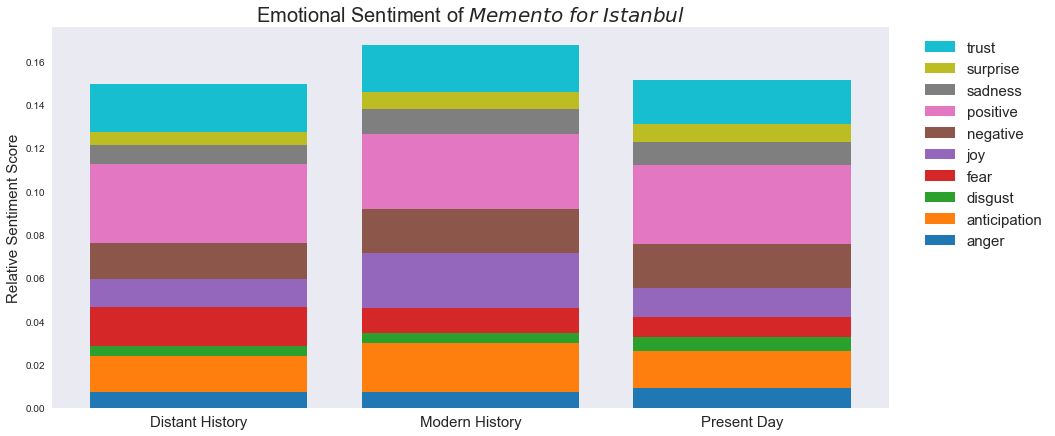

In [45]:
tab10 = matplotlib.cm.get_cmap('tab10')

df2 = df[df['period'].isin(['Distant History', 'Modern History', 'Present Day'])]

periods = ['Distant History', 'Modern History', 'Present Day']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(emotions):
    y = df2.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

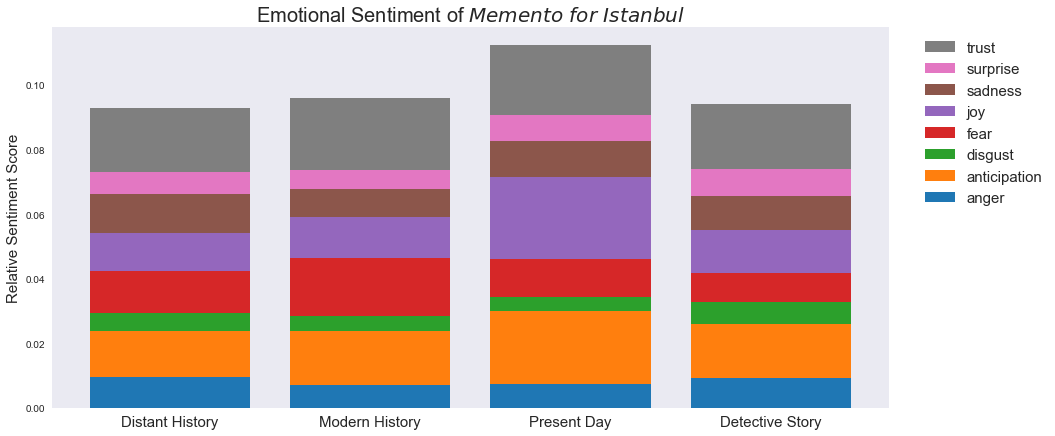

In [46]:
tab10 = matplotlib.cm.get_cmap('tab10')

periods = ['Distant History', 'Modern History', 'Present Day', 'Detective Story']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']):
    y = df.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

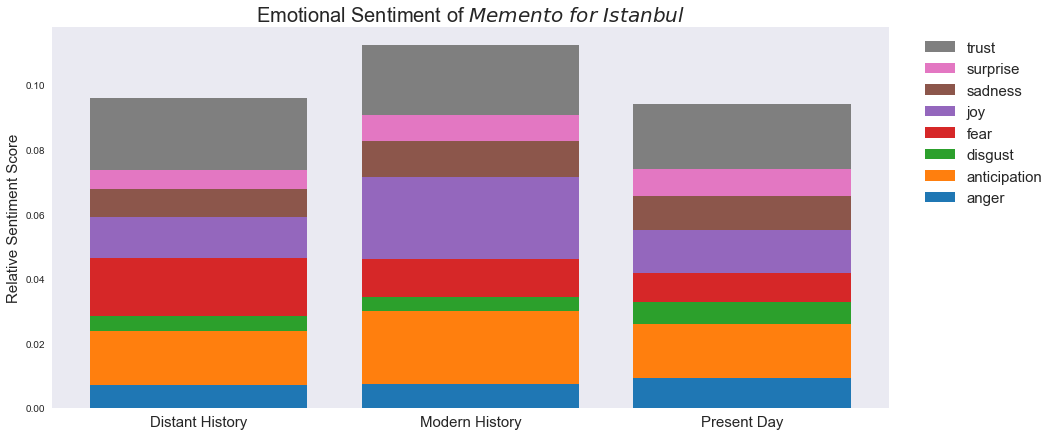

In [47]:
tab10 = matplotlib.cm.get_cmap('tab10')

df2 = df[df['period'].isin(['Distant History', 'Modern History', 'Present Day'])]

periods = ['Distant History', 'Modern History', 'Present Day']
margin_bottom = np.zeros(len(periods))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

for c, emotion in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']):
    y = df2.groupby('period')[emotion].mean()
    plt.bar(periods, y, bottom=margin_bottom, label=emotion, color=(tab10(c)))
    margin_bottom += y

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
plt.title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=20)
plt.xticks(periods, periods, fontsize=15)
plt.ylabel('Relative Sentiment Score', fontsize=15)
# plt.yticks([])
ax.grid(False)
plt.show()

In [48]:
df.head()

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
0,1,Distant History,Byzantium\n\nKing Byzas’ Fabled City\n\n\n\nD\...,55,0.04070,0.090073,0.061400,0.848527,0.017586,0.023981,0.007194,0.018385,0.015987,0.035971,0.068745,0.017586,0.007994,0.019984,1251
1,2,Detective Story,The Crescent and the Star\n\nThe victim’s eyes...,8,-0.12115,0.009125,0.061125,0.929750,0.021164,0.026455,0.010582,0.021164,0.005291,0.026455,0.037037,0.015873,0.010582,0.021164,189
2,3,Present Day,"Two battered old ferries, those long-suffering...",2,0.58420,0.140500,0.000000,0.859500,0.030303,0.030303,0.015152,0.015152,0.030303,0.015152,0.075758,0.015152,0.030303,0.045455,66
3,4,Modern History,"I was taken back to the old days, the good old...",1,0.68580,0.170000,0.058000,0.772000,0.000000,0.019231,0.000000,0.000000,0.038462,0.019231,0.038462,0.019231,0.019231,0.019231,52
4,5,Detective Story,I suddenly felt someone’s eyes on me. Lifting ...,43,-0.18296,0.039953,0.075581,0.884465,0.008761,0.012516,0.001252,0.015019,0.003755,0.030038,0.013767,0.013767,0.002503,0.008761,799


In [49]:
df_ave = df.groupby('period')[['compound', 'pos', 'neg',
       'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust']].mean()

In [50]:
df_ave.head()

,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
period,,,,,,,,,,,,,,
Detective Story,-0.034454,0.072087,0.069192,0.858728,0.009551,0.014237,0.005533,0.013174,0.011686,0.021205,0.031238,0.011949,0.006969,0.019726
Distant History,0.138068,0.070968,0.038311,0.890732,0.007171,0.016683,0.004589,0.017897,0.012925,0.016626,0.036733,0.008468,0.006038,0.022131
Modern History,0.175897,0.083966,0.032749,0.883294,0.007282,0.022584,0.004475,0.011657,0.025590,0.020053,0.034961,0.011180,0.007860,0.021648
Present Day,0.143658,0.082560,0.037913,0.879493,0.009290,0.016794,0.006720,0.009060,0.013212,0.020476,0.036389,0.010624,0.008323,0.020244


In [51]:
df_ave.to_csv('df_ave.csv')

In [52]:
min_emotion = min(df_ave[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']].min())
max_emotion = max(df_ave[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']].max())

min_sentiment = min(df_ave[['pos', 'neg', 'neu']].min())
max_sentiment = max(df_ave[['pos', 'neg', 'neu']].max())

min_compound = df_ave['compound'].min()
max_compound = df_ave['compound'].max()

df_ave_norm = df_ave[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
       'positive', 'sadness', 'surprise', 'trust']].apply(lambda x: (x - min_emotion) / (max_emotion - min_emotion))

df_ave_norm[['pos', 'neg', 'neu']] = df_ave[['pos', 'neg', 'neu']].apply(lambda x: (x - min_sentiment) / (max_sentiment - min_sentiment))

df_ave_norm['compound'] = df_ave['compound'].apply(lambda x: (x - df_ave['compound'].min()) / (df_ave['compound'].max() - df_ave['compound'].min())) * 2 - 1

df_ave_norm = df_ave_norm[['compound', 'pos', 'neg', 'neu', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]

df_ave_norm.head()

,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
period,,,,,,,,,,,,,,
Detective Story,-1.000000,0.045849,0.042474,0.962699,0.157367,0.302623,0.032800,0.269672,0.223558,0.518628,0.829645,0.231699,0.077307,0.472793
Distant History,0.640325,0.044545,0.006483,1.000000,0.083570,0.378455,0.003537,0.416096,0.261956,0.376688,1.000000,0.123785,0.048444,0.547330
Modern History,1.000000,0.059694,0.000000,0.991331,0.087038,0.561394,0.000000,0.222657,0.654559,0.482934,0.945069,0.207857,0.104931,0.532360
Present Day,0.693473,0.058056,0.006019,0.986901,0.149262,0.381888,0.069609,0.142125,0.270865,0.496048,0.989333,0.190612,0.119279,0.488830


In [53]:
(df_ave['compound'] - min(df_ave['compound'])) / (max(df_ave['compound']) - min(df_ave['compound'])) * 2 - 1

period
Detective Story   -1.000000
Distant History    0.640325
Modern History     1.000000
Present Day        0.693473
Name: compound, dtype: float64

In [54]:
df_ave.to_csv('averages.csv')

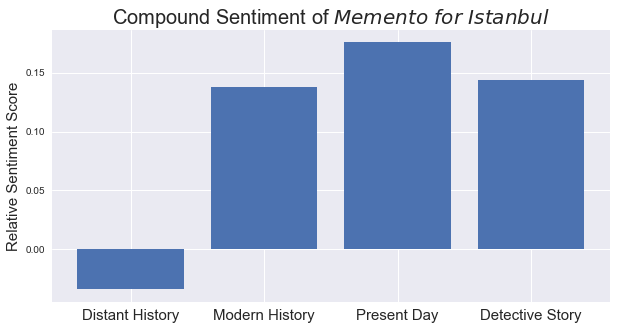

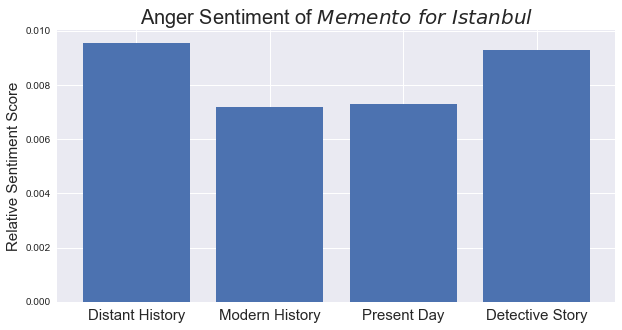

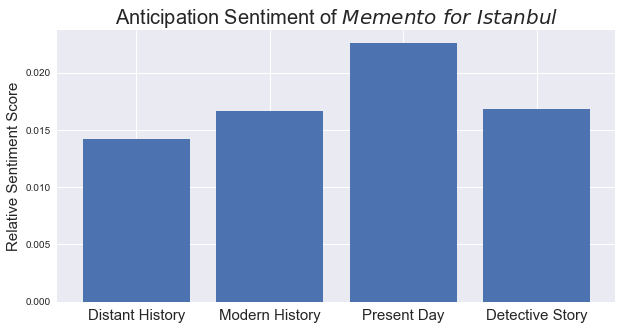

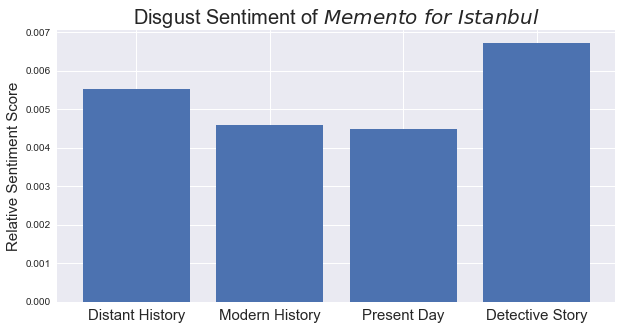

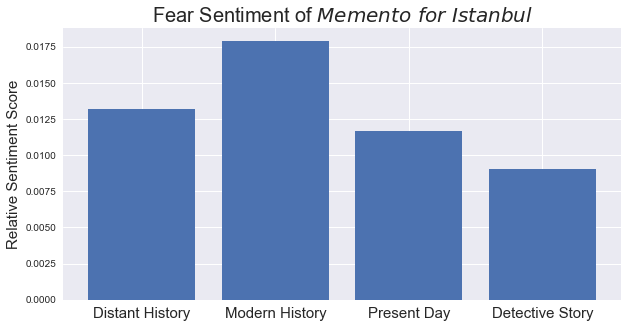

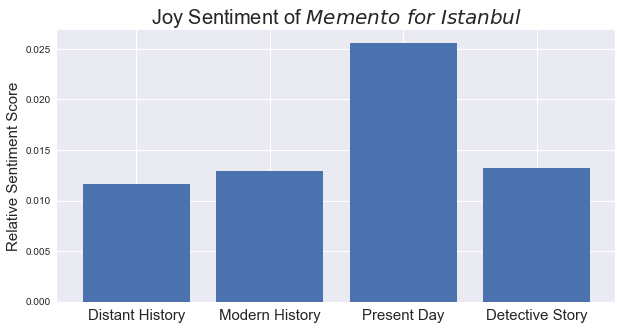

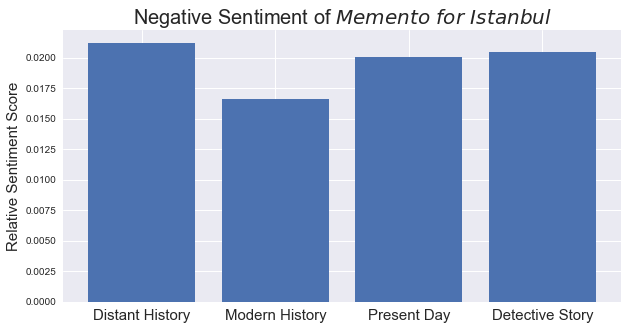

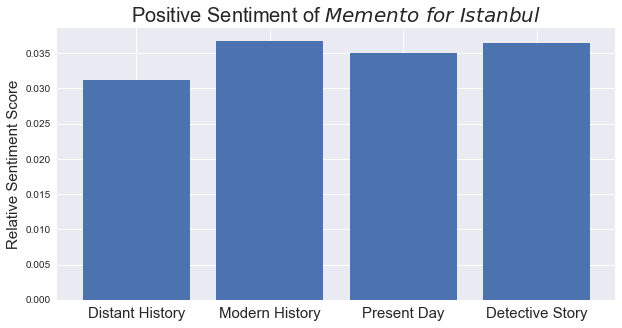

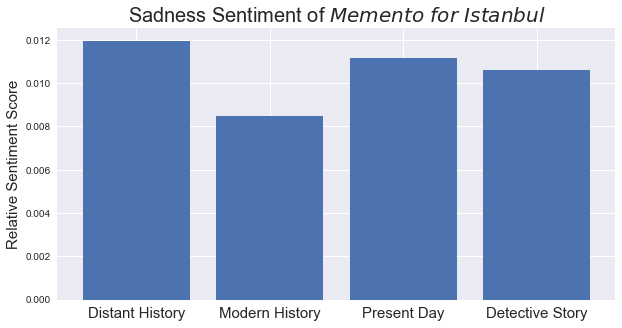

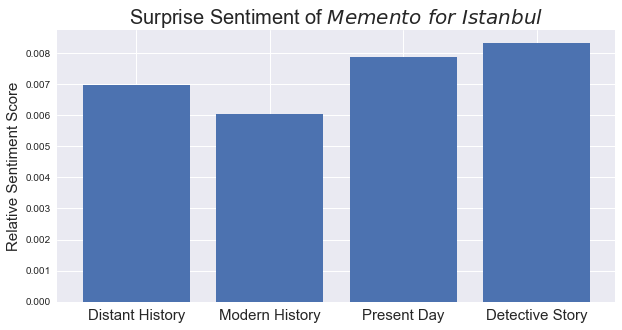

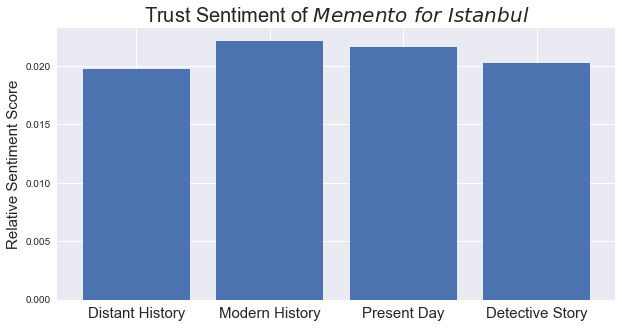

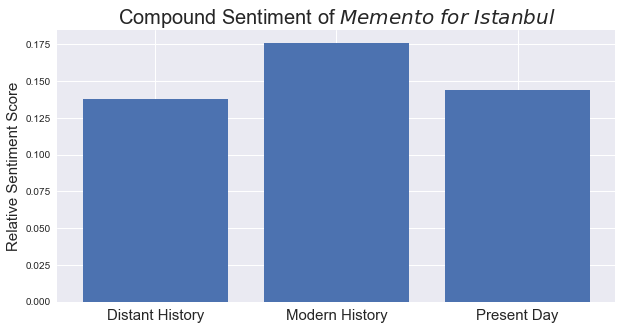

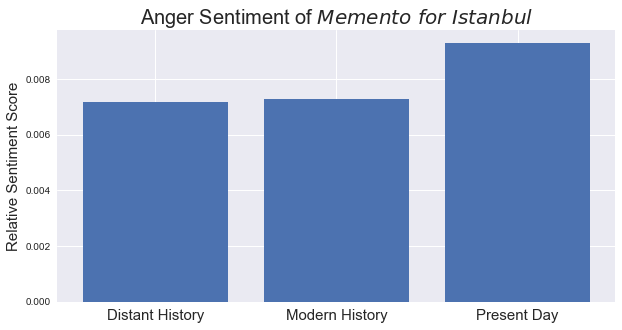

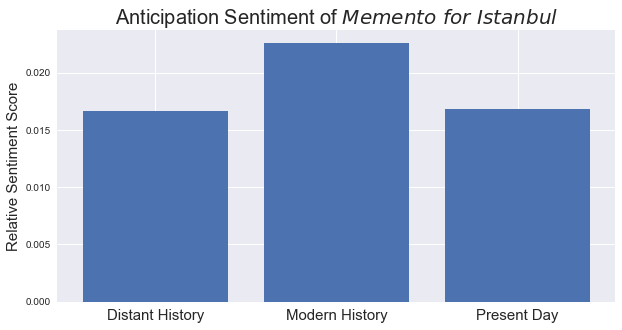

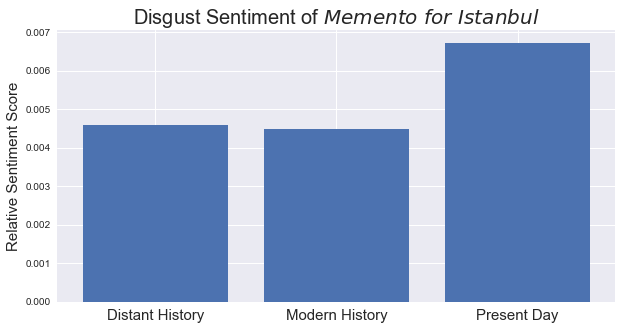

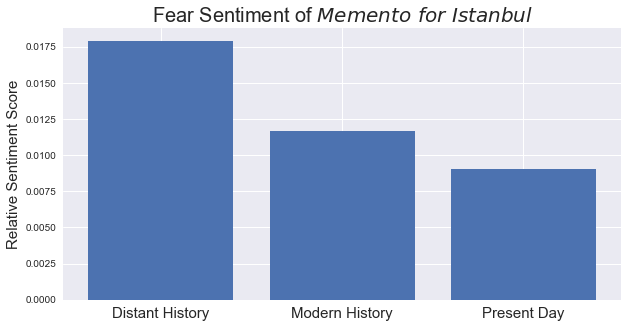

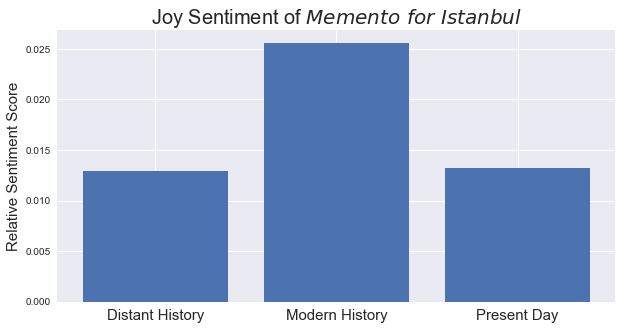

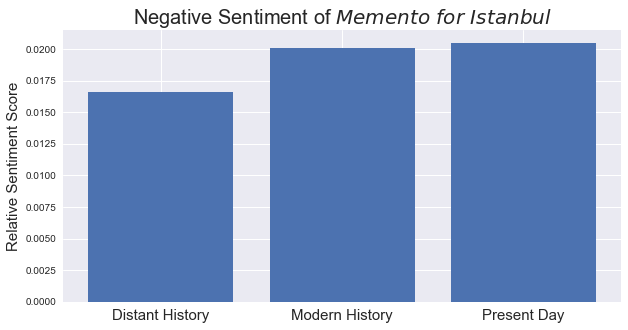

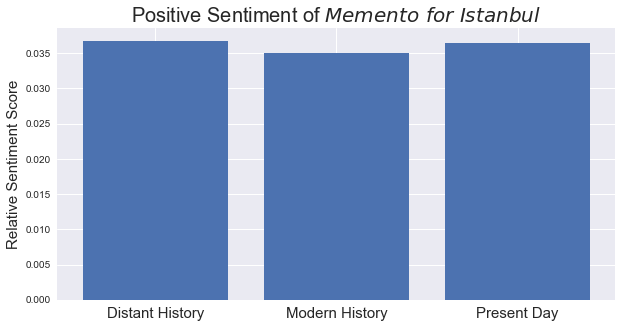

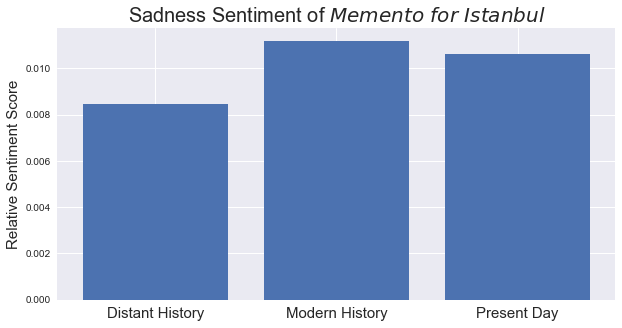

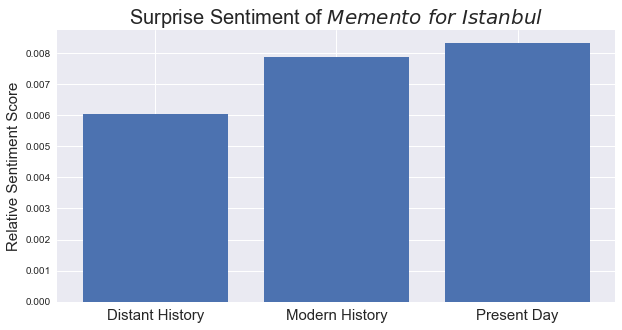

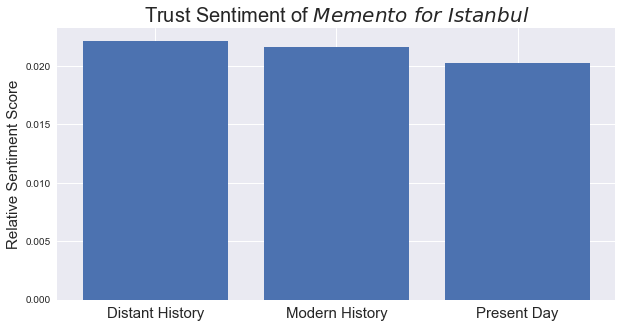

In [55]:
for periods in [['Distant History', 'Modern History', 'Present Day', 'Detective Story'], ['Distant History', 'Modern History', 'Present Day']]:
    for col in ['compound', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']:
        plt.figure(figsize=(10, 5))
        plt.bar(x=periods, height=df_ave[df_ave.index.isin(periods)][col])
        plt.title('{} Sentiment of $Memento\ for\ Istanbul$'.format(col.title()), fontsize=20)
        plt.ylabel('Relative Sentiment Score', fontsize=15)
        plt.xticks(periods, periods, fontsize=15)
        plt.show()

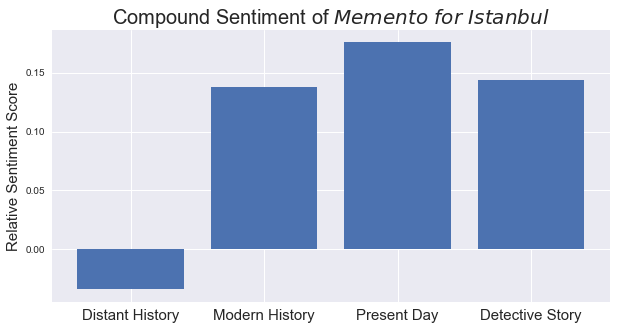

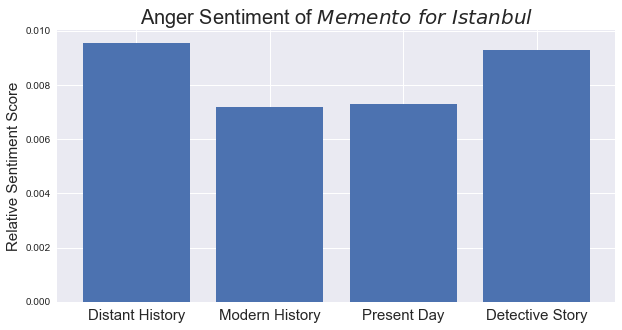

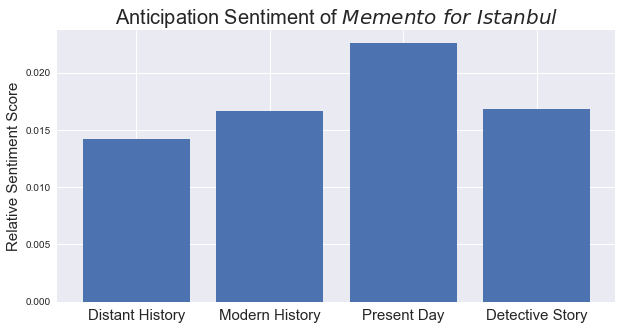

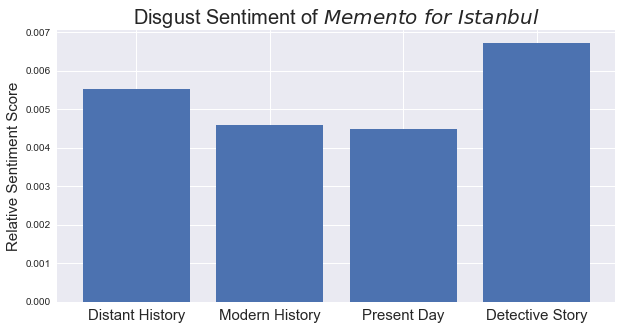

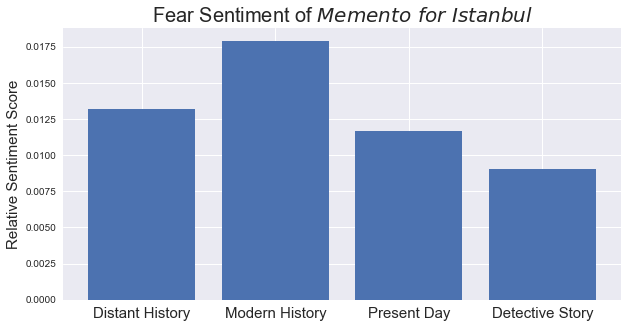

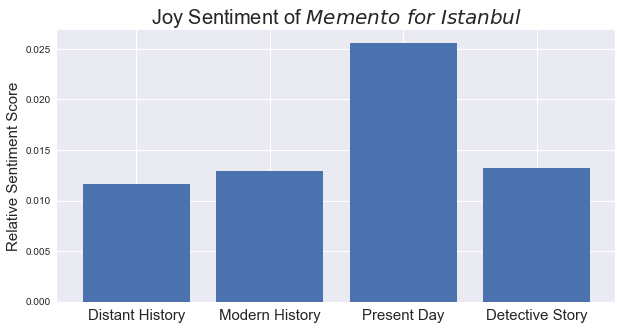

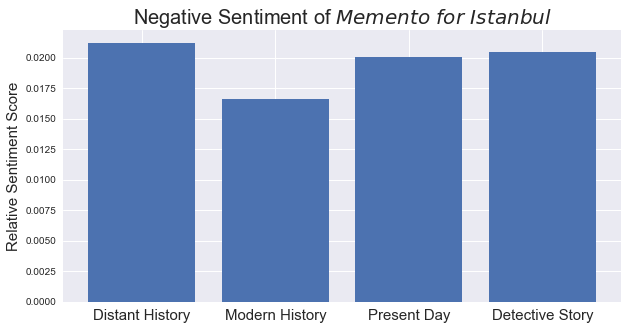

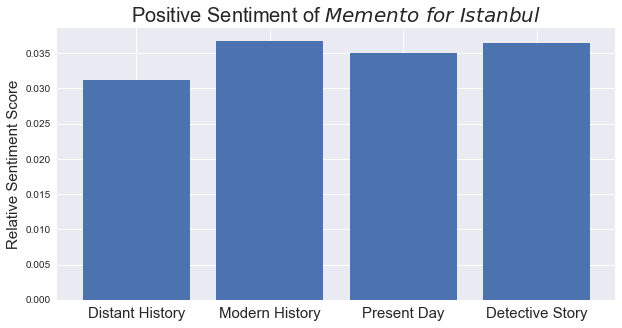

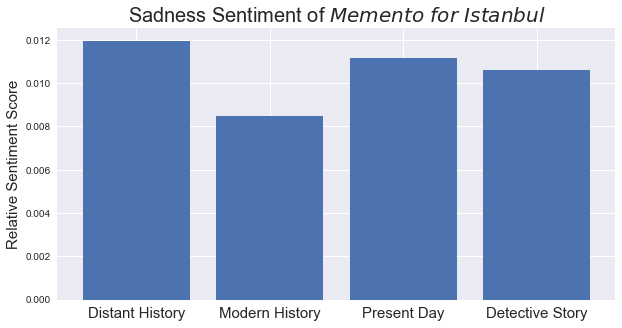

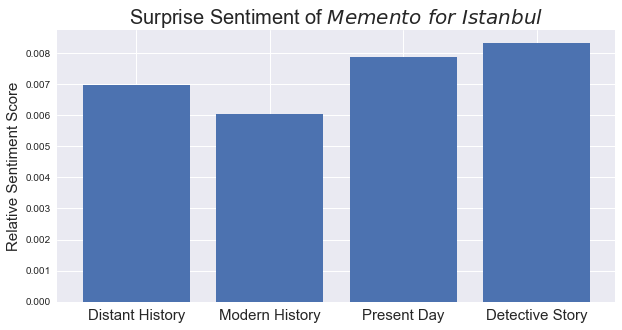

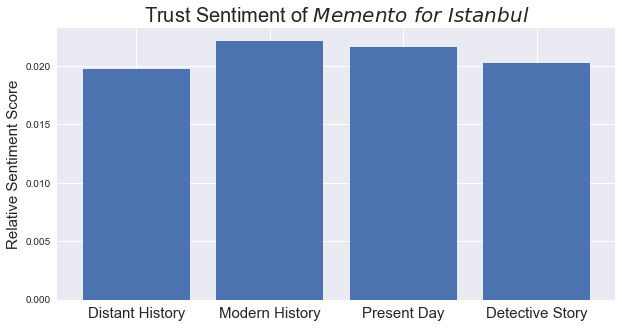

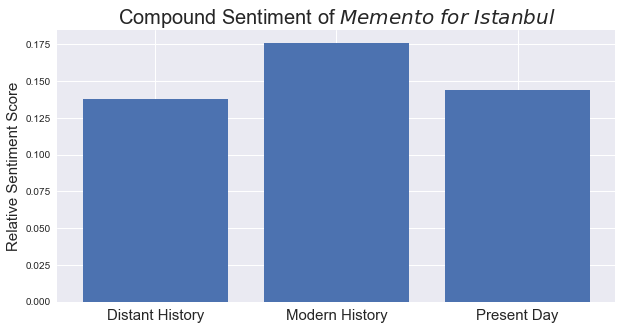

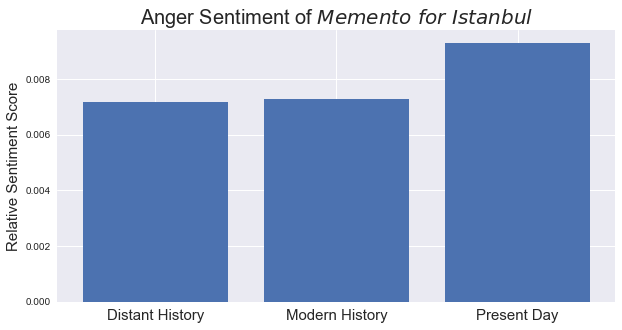

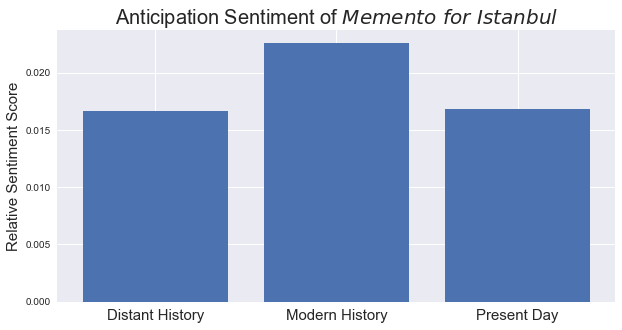

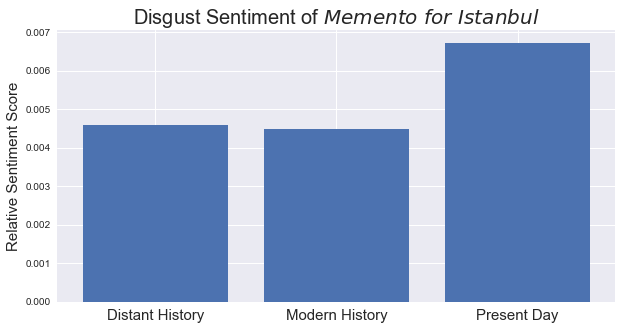

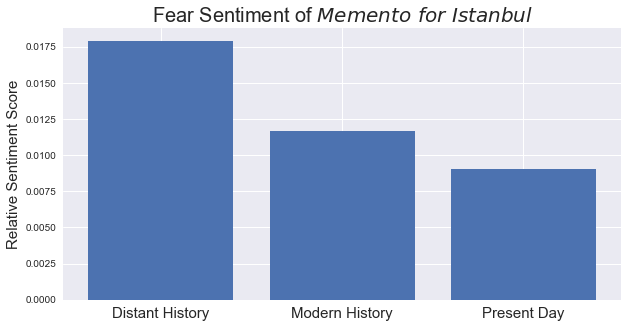

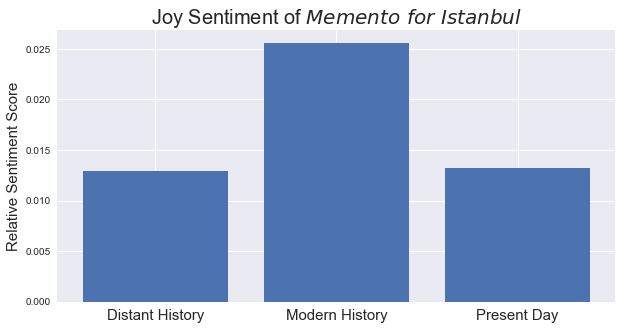

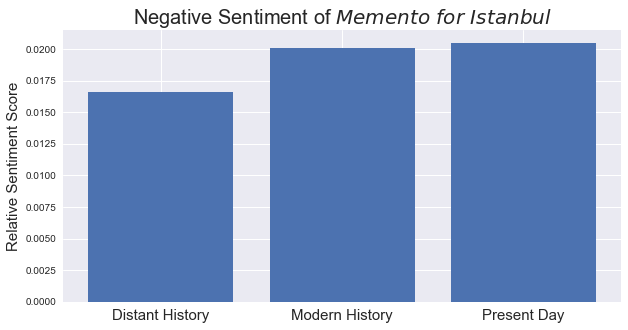

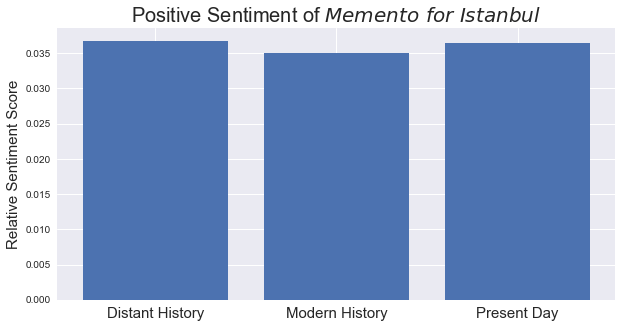

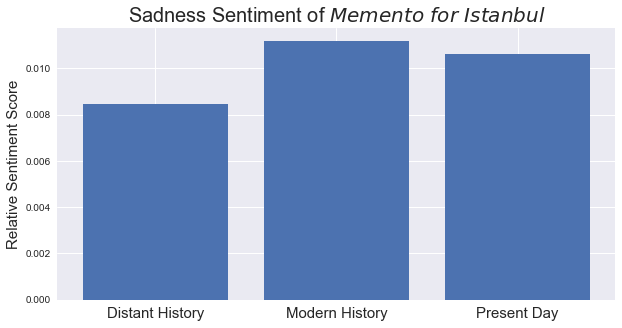

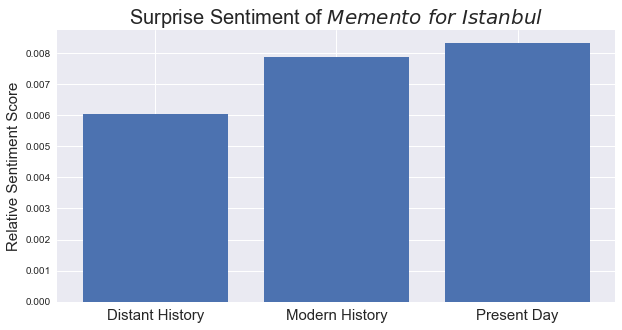

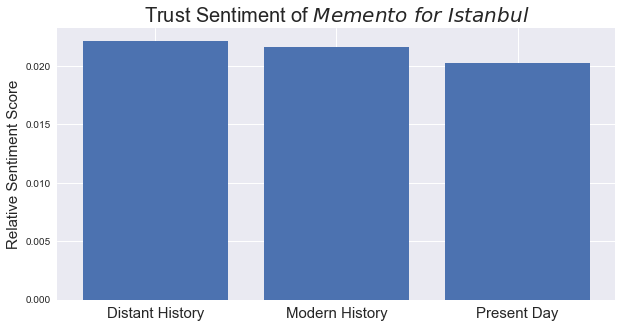

In [56]:
for periods in [['Distant History', 'Modern History', 'Present Day', 'Detective Story'], ['Distant History', 'Modern History', 'Present Day']]:
    for col in ['compound', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']:
        plt.figure(figsize=(10, 5))
        plt.bar(x=periods, height=df_ave[df_ave.index.isin(periods)][col])
        plt.title('{} Sentiment of $Memento\ for\ Istanbul$'.format(col.title()), fontsize=20)
        plt.ylabel('Relative Sentiment Score', fontsize=15)
        plt.xticks(periods, periods, fontsize=15)
        plt.show()

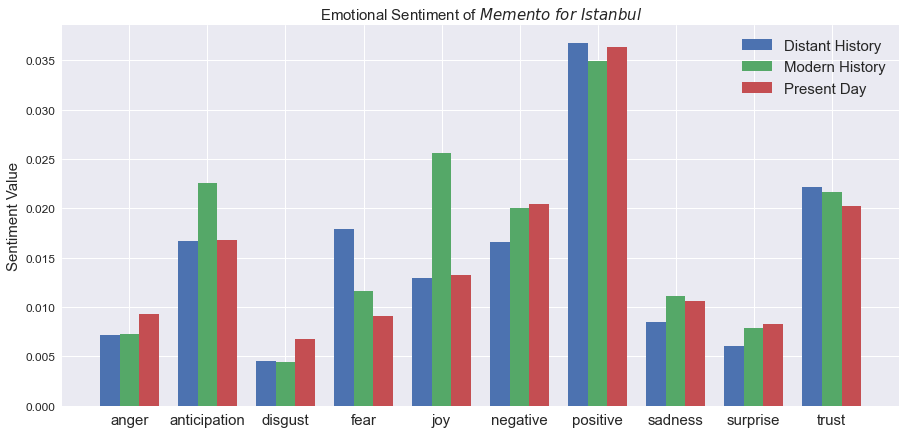

In [57]:
N = 10
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

distant = df_ave.loc['Distant History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
modern = df_ave.loc['Modern History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
present = df_ave.loc['Present Day'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, distant, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'], fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Distant History', 'Modern History', 'Present Day'), fontsize=15)

plt.show()

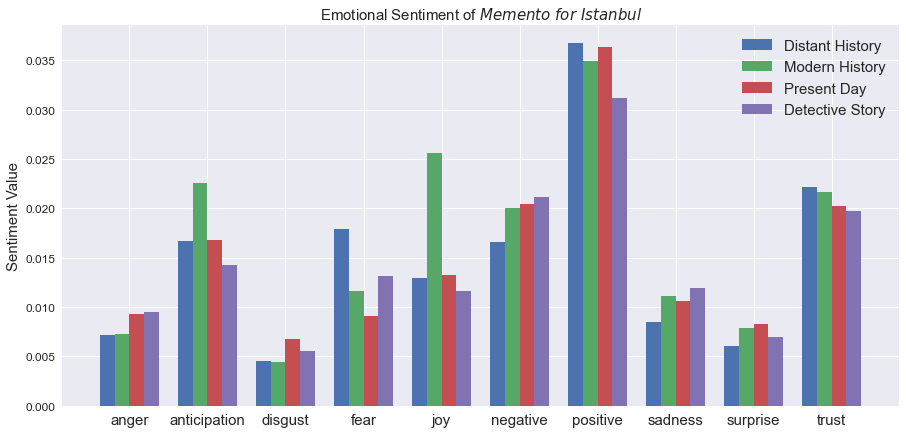

In [58]:
N = 10
distant = df_ave.loc['Distant History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
modern = df_ave.loc['Modern History'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
present = df_ave.loc['Present Day'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]
detective = df_ave.loc['Detective Story'][['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']]

ind = np.arange(N)  # the x locations for the groups
width = 0.1875       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, distant, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)
rects4 = ax.bar(ind+3*width, detective, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width*1.5)
ax.tick_params(labelsize=12)
ax.set_xticklabels(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust'], fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('Distant History', 'Modern History', 'Present Day', 'Detective Story'), fontsize=15)

plt.show()

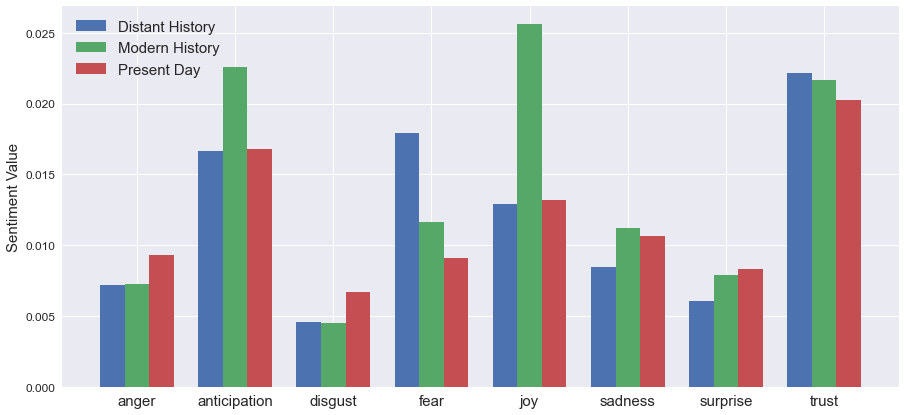

In [59]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
N = len(emotions)

distant = df_ave.loc['Distant History'][emotions]
modern = df_ave.loc['Modern History'][emotions]
present = df_ave.loc['Present Day'][emotions]

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, distant, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
# ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width)
ax.tick_params(labelsize=12)
ax.set_xticklabels(emotions, fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0]), ('Distant History', 'Modern History', 'Present Day'), fontsize=15)

plt.show()

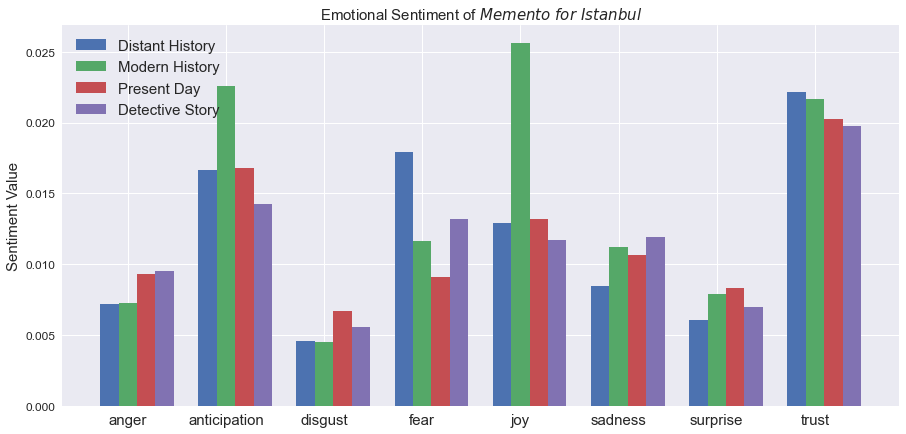

In [60]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
N = len(emotions)

distant = df_ave.loc['Distant History'][emotions]
modern = df_ave.loc['Modern History'][emotions]
present = df_ave.loc['Present Day'][emotions]
detective = df_ave.loc['Detective Story'][emotions]

ind = np.arange(N)  # the x locations for the groups
width = 0.1875       # the width of the bars

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, distant, width)
rects2 = ax.bar(ind+width, modern, width)
rects3 = ax.bar(ind+2*width, present, width)
rects4 = ax.bar(ind+3*width, detective, width)

ax.set_ylabel('Sentiment Value', fontsize=15)
ax.set_title('Emotional Sentiment of $Memento\ for\ Istanbul$', fontsize=15)
ax.set_xticks(ind + width)
ax.tick_params(labelsize=12)
ax.set_xticklabels(emotions, fontsize=15)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('Distant History', 'Modern History', 'Present Day', 'Detective Story'), fontsize=15)

plt.show()

# LDA

In [61]:
import operator
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# nltk for lemmatization
from nltk.stem import WordNetLemmatizer 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [62]:
data = [section[2].replace('\n', ' ') for section in novel]

In [63]:
text_df = df.groupby('period')['text'].apply(lambda x: ','.join(x)).reset_index()
data = text_df['text'].tolist()
# text_df

In [64]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [65]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [66]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(word) for word in sent])
    return texts_out

In [67]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

lemmatizer = WordNetLemmatizer() 

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

In [68]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [70]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"one" + 0.008*"house" + 0.007*"used" + 0.006*"said" + 0.006*"old" + '
  '0.006*"like" + 0.005*"back" + 0.005*"even" + 0.005*"never" + '
  '0.005*"street"'),
 (1,
  '0.001*"said" + 0.001*"ali" + 0.001*"u" + 0.001*"know" + 0.001*"would" + '
  '0.001*"one" + 0.000*"like" + 0.000*"time" + 0.000*"eye" + 0.000*"still"'),
 (2,
  '0.001*"said" + 0.001*"one" + 0.001*"ali" + 0.001*"u" + 0.000*"would" + '
  '0.000*"like" + 0.000*"know" + 0.000*"look" + 0.000*"time" + 0.000*"city"'),
 (3,
  '0.001*"said" + 0.001*"one" + 0.001*"ali" + 0.001*"u" + 0.001*"would" + '
  '0.000*"like" + 0.000*"time" + 0.000*"back" + 0.000*"look" + 0.000*"going"'),
 (4,
  '0.001*"said" + 0.001*"one" + 0.001*"ali" + 0.001*"would" + 0.001*"u" + '
  '0.001*"know" + 0.000*"like" + 0.000*"two" + 0.000*"still" + 0.000*"time"'),
 (5,
  '0.001*"said" + 0.001*"u" + 0.001*"one" + 0.000*"ali" + 0.000*"would" + '
  '0.000*"could" + 0.000*"like" + 0.000*"around" + 0.000*"know" + '
  '0.000*"even"'),
 (6,
  '0.001*"said"

In [71]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -8.139258483221719
Coherence Score:  0.2639643905823658


In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [73]:
mallet_path = r'C:\\mallet\\bin\\mallet.bat'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [74]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=1000, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('necdet', 0.0403125),
   ('put', 0.0275),
   ('table', 0.0234375),
   ('word', 0.0234375),
   ('mr', 0.018125),
   ('began', 0.0159375),
   ('telling', 0.0159375),
   ('miss_barkın', 0.014375),
   ('seat', 0.0140625),
   ('smiled', 0.0128125)]),
 (1,
  [('mosque', 0.041316685584562994),
   ('palace', 0.027014755959137344),
   ('wall', 0.023382519863791147),
   ('time', 0.01975028376844495),
   ('building', 0.018388195232690124),
   ('sea', 0.0170261066969353),
   ('man', 0.01634506242905789),
   ('place', 0.01634506242905789),
   ('church', 0.01634506242905789),
   ('hagia_sophia', 0.01611804767309875)]),
 (2,
  [('yekta', 0.060517038777908344),
   ('evgenia', 0.052878965922444184),
   ('thought', 0.04171562867215041),
   ('thing', 0.03965922444183314),
   ('life', 0.02262044653349001),
   ('wrong', 0.018507638072855465),
   ('home', 0.01762632197414806),
   ('started', 0.01615746180963572),
   ('hope', 0.01527614571092832),
   ('truth', 0.01410105757931845)]),
 (3,
  [('end',

In [75]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [76]:
# Can take a long time to run.
limit=75; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 4-topic model
Calculating 6-topic model
Calculating 8-topic model
Calculating 10-topic model
Calculating 12-topic model
Calculating 14-topic model
Calculating 16-topic model
Calculating 18-topic model
Calculating 20-topic model
Calculating 22-topic model
Calculating 24-topic model
Calculating 26-topic model
Calculating 28-topic model
Calculating 30-topic model
Calculating 32-topic model
Calculating 34-topic model
Calculating 36-topic model
Calculating 38-topic model
Calculating 40-topic model
Calculating 42-topic model
Calculating 44-topic model
Calculating 46-topic model
Calculating 48-topic model
Calculating 50-topic model
Calculating 52-topic model
Calculating 54-topic model
Calculating 56-topic model
Calculating 58-topic model
Calculating 60-topic model
Calculating 62-topic model
Calculating 64-topic model
Calculating 66-topic model
Calculating 68-topic model
Calculating 70-topic model
Calculating 72-topic model
Calculating 74-topic model


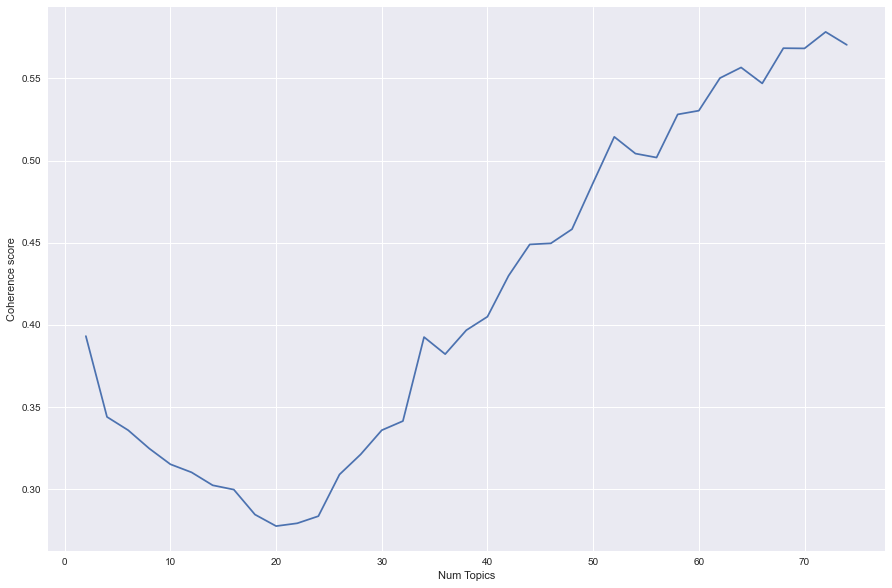

In [77]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [78]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.393182
Num Topics = 4  has Coherence Value of 0.344039
Num Topics = 6  has Coherence Value of 0.335965
Num Topics = 8  has Coherence Value of 0.324814
Num Topics = 10  has Coherence Value of 0.315232
Num Topics = 12  has Coherence Value of 0.31033
Num Topics = 14  has Coherence Value of 0.302456
Num Topics = 16  has Coherence Value of 0.299835
Num Topics = 18  has Coherence Value of 0.284656
Num Topics = 20  has Coherence Value of 0.277637
Num Topics = 22  has Coherence Value of 0.279343
Num Topics = 24  has Coherence Value of 0.283672
Num Topics = 26  has Coherence Value of 0.309024
Num Topics = 28  has Coherence Value of 0.321239
Num Topics = 30  has Coherence Value of 0.335962
Num Topics = 32  has Coherence Value of 0.341517
Num Topics = 34  has Coherence Value of 0.392602
Num Topics = 36  has Coherence Value of 0.382229
Num Topics = 38  has Coherence Value of 0.396789
Num Topics = 40  has Coherence Value of 0.405007
Num Topics = 42  has Cohe

In [79]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 24
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(num_topics=1000, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(17,
  '0.051*"street" + 0.036*"kid" + 0.024*"view" + 0.024*"ground" + '
  '0.021*"drove" + 0.018*"wooden" + 0.018*"home" + 0.017*"image" + '
  '0.017*"tomb" + 0.017*"neighbourhood"'),
 (31,
  '0.021*"genuine" + 0.021*"bridge" + 0.019*"replaced" + 0.019*"chose" + '
  '0.019*"drunk" + 0.017*"class" + 0.015*"eat" + 0.013*"night_watchman" + '
  '0.013*"baby" + 0.013*"weapon"'),
 (12,
  '0.056*"demir" + 0.046*"coin" + 0.045*"yekta" + 0.034*"victim" + 0.033*"sir" '
  '+ 0.031*"found" + 0.027*"necdet" + 0.026*"evgenia" + 0.025*"omer" + '
  '0.021*"find"'),
 (13,
  '0.028*"trembling" + 0.022*"leaned_forward" + 0.017*"nature" + '
  '0.017*"restaurant" + 0.015*"rug" + 0.015*"many_times" + 0.013*"moved" + '
  '0.013*"hint" + 0.013*"viewed" + 0.013*"sight"'),
 (3,
  '0.024*"realise" + 0.024*"blood" + 0.021*"al" + 0.021*"centre" + '
  '0.019*"plastic_bag" + 0.017*"locked" + 0.017*"unusual" + 0.017*"departed" + '
  '0.017*"figure" + 0.017*"learning"'),
 (27,
  '0.027*"pay" + 0.027*"quick" + 0.025*

In [80]:
optimal_model.show_topic(0,15)

[('emperor', 0.1152073732718894),
 ('sultan', 0.06820276497695853),
 ('deity', 0.05069124423963134),
 ('empire', 0.034101382488479264),
 ('rome', 0.027649769585253458),
 ('began', 0.02304147465437788),
 ('architect', 0.022119815668202765),
 ('capital', 0.017511520737327188),
 ('men', 0.01566820276497696),
 ('allah', 0.01566820276497696),
 ('sword', 0.014746543778801843),
 ('honour', 0.013824884792626729),
 ('kostantiniyye', 0.011981566820276499),
 ('sultan_suleyman', 0.011981566820276499),
 ('empress', 0.010138248847926268)]

In [81]:
for topic in sorted(optimal_model.show_topics(num_topics=1000, num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['emperor', 'sultan', 'deity', 'empire', 'rome', 'began', 'architect', 'capital', 'men', 'allah']
Topic 1: ['send', 'called', 'chest', 'attempt', 'evil', 'stench', 'bright', 'stair', 'object', 'month']
Topic 2: ['shot', 'allah', 'driver', 'operation', 'impossible', 'wearing', 'barked', 'zeynep', 'crime_scene', 'discussing']
Topic 3: ['realise', 'blood', 'al', 'centre', 'plastic_bag', 'locked', 'unusual', 'departed', 'figure', 'learning']
Topic 4: ['guzide', 'throat', 'child', 'sticking', 'pocket', 'putting', 'wrong', 'dad', 'foot', 'stopping']
Topic 5: ['time', 'hand', 'man', 'front', 'thought', 'make', 'woman', 'end', 'set', 'blood']
Topic 6: ['house', 'church', 'place', 'mosque', 'young', 'water', 'greek', 'day', 'stood', 'byzantine']
Topic 7: ['talking', 'past', 'looked', 'coming', 'strange', 'managed', 'hell', 'black', 'lying', 'air']
Topic 8: ['hagia_sophia', 'constantinople', 'gazed_upon', 'creation', 'conquered', 'race', 'spectacular', 'egypt', 'achievement', 'chariot']

In [82]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, 'First', topic_num, round(prop_topic,4), topic_keywords]), ignore_index=True)
            elif j == 1:  # => second-highest topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, 'Second', topic_num, round(prop_topic,4), topic_keywords]), ignore_index=True)
            elif j == 2:  # => third-highest topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([i, 'Third', topic_num, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Document_No', 'Topic_Rank', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.copy()
df_dominant_topic['Document_No'] = df_dominant_topic['Document_No'].astype(int)
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
df_dominant_topic.columns = ['Document_No', 'Topic_Rank', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic[['Document_No', 'Topic_Rank',  'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]

,Document_No,Topic_Rank,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,First,36,0.0979,"ali, eye, looked, head, told, friend, wanted, ..."
1,0,Second,12,0.0897,"demir, coin, yekta, victim, sir, found, necdet..."
2,0,Third,5,0.0721,"time, hand, man, front, thought, make, woman, ..."
3,1,First,42,0.1733,"city, mosque, building, built, palace, wall, c..."
4,1,Second,16,0.1242,"constantine, city, year, world, brought, great..."
5,1,Third,0,0.1194,"emperor, sultan, deity, empire, rome, began, a..."
6,2,First,6,0.1891,"house, church, place, mosque, young, water, gr..."
7,2,Second,28,0.1584,"memory, uncle, ended, learnt, bother, poem, au..."
8,2,Third,17,0.1387,"street, kid, view, ground, drove, wooden, home..."
9,3,First,42,0.1811,"city, mosque, building, built, palace, wall, c..."


In [83]:
docs = text_df['period'].unique().tolist()

for idx, row in df_dominant_topic.iterrows():
    print('{}, {} topic : {}'.format(docs[row['Document_No']], row['Topic_Rank'], row['Keywords'].split(', ')[:10]))

Detective Story, First topic : ['ali', 'eye', 'looked', 'head', 'told', 'friend', 'wanted', 'question', 'leyla_barkın', 'moment']
Detective Story, Second topic : ['demir', 'coin', 'yekta', 'victim', 'sir', 'found', 'necdet', 'evgenia', 'omer', 'find']
Detective Story, Third topic : ['time', 'hand', 'man', 'front', 'thought', 'make', 'woman', 'end', 'set', 'blood']
Distant History, First topic : ['city', 'mosque', 'building', 'built', 'palace', 'wall', 'column', 'made', 'sea', 'istanbul']
Distant History, Second topic : ['constantine', 'city', 'year', 'world', 'brought', 'great', 'sultan_mehmed', 'day', 'god', 'byzantium']
Distant History, Third topic : ['emperor', 'sultan', 'deity', 'empire', 'rome', 'began', 'architect', 'capital', 'men', 'allah']
Modern History, First topic : ['house', 'church', 'place', 'mosque', 'young', 'water', 'greek', 'day', 'stood', 'byzantine']
Modern History, Second topic : ['memory', 'uncle', 'ended', 'learnt', 'bother', 'poem', 'aunt', 'id', 'moved', 'roll

In [84]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Document_No', 'Topic_Rank', 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet[['Topic_Num', "Topic_Perc_Contrib", "Keywords"]]

,Topic_Num,Topic_Perc_Contrib,Keywords
0,0.0,0.1194,"emperor, sultan, deity, empire, rome, began, a..."
1,5.0,0.0721,"time, hand, man, front, thought, make, woman, ..."
2,6.0,0.1891,"house, church, place, mosque, young, water, gr..."
3,12.0,0.0897,"demir, coin, yekta, victim, sir, found, necdet..."
4,16.0,0.1242,"constantine, city, year, world, brought, great..."
5,17.0,0.1387,"street, kid, view, ground, drove, wooden, home..."
6,21.0,0.0965,"tourist, boat, garden, breeze, leading, world,..."
7,28.0,0.1584,"memory, uncle, ended, learnt, bother, poem, au..."
8,36.0,0.0979,"ali, eye, looked, head, told, friend, wanted, ..."
9,42.0,0.1811,"city, mosque, building, built, palace, wall, c..."


In [85]:
# for idx, row in sent_topics_sorteddf_mallet.iterrows():
#     print('Topic number {}'.format(int(row['Topic_Num'])))
#     print('Keywords: {}'.format(row['Keywords']))
#     print()
#     print(row['Text'])
#     print()

In [86]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(drop=True)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).reset_index(drop=True)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"emperor, sultan, deity, empire, rome, began, a...",2,0.1667
1,5.0,"time, hand, man, front, thought, make, woman, ...",2,0.1667
2,6.0,"house, church, place, mosque, young, water, gr...",1,0.0833
3,12.0,"demir, coin, yekta, victim, sir, found, necdet...",1,0.0833
4,16.0,"constantine, city, year, world, brought, great...",1,0.0833
5,17.0,"street, kid, view, ground, drove, wooden, home...",1,0.0833
6,21.0,"tourist, boat, garden, breeze, leading, world,...",1,0.0833
7,28.0,"memory, uncle, ended, learnt, bother, poem, au...",1,0.0833
8,36.0,"ali, eye, looked, head, told, friend, wanted, ...",1,0.0833
9,42.0,"city, mosque, building, built, palace, wall, c...",1,0.0833


In [87]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_colwidth', -1)
    display(df_dominant_topics)

<ipython-input-87-ac90e0fd5d9d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"emperor, sultan, deity, empire, rome, began, architect, capital, men, allah",2,0.1667
1,5.0,"time, hand, man, front, thought, make, woman, end, set, blood",2,0.1667
2,6.0,"house, church, place, mosque, young, water, greek, day, stood, byzantine",1,0.0833
3,12.0,"demir, coin, yekta, victim, sir, found, necdet, evgenia, omer, find",1,0.0833
4,16.0,"constantine, city, year, world, brought, great, sultan_mehmed, day, god, byzantium",1,0.0833
5,17.0,"street, kid, view, ground, drove, wooden, home, image, tomb, neighbourhood",1,0.0833
6,21.0,"tourist, boat, garden, breeze, leading, world, tree, style, club, sweet",1,0.0833
7,28.0,"memory, uncle, ended, learnt, bother, poem, aunt, id, moved, roll",1,0.0833
8,36.0,"ali, eye, looked, head, told, friend, wanted, question, leyla_barkın, moment",1,0.0833
9,42.0,"city, mosque, building, built, palace, wall, column, made, sea, istanbul",1,0.0833


In [88]:
for section in novel:
    if section[1] == 'Modern History':
        sentences = tokenize.sent_tokenize(section[2])
        for sentence in sentences:
            if re.search(r'general', sentence):
                print(sentence)

The whole of Istanbul had been turned into a hunting ground for the generals and we were the lapdogs doing their dirty work… If something, anything, was reported in our area, we all had to go, it didn’t matter who or where.
The generals classified anyone who stood up to them as a terrorist or traitor and it was our job to catch them, torture them until we had a confession and then have them disposed of.


In [93]:
for section in novel:
    if re.search(r'general', section[2]):
        print('=============================')
        print('   Section {}: {}'.format(section[0], section[1]))
        sentences = tokenize.sent_tokenize(section[2])
        for sentence in sentences:
            if re.search(r'general', sentence):
                print(sentence)
                print()

   Section 88: Detective Story
The cab drivers, who were generally on decent terms with the police, didn’t even bother looking up.

   Section 93: Distant History
“One moment… Byzas’ founding of the city is generally seen as having taken place at around 660BC… Constantine’s declaration of the city as his capital was 330AD… That makes it… Around nine hundred and ninety years.”

“So basically a thousand.”

“That’s easy then,” said Ali, hardly able to hide his excitement.

   Section 97: Modern History
The whole of Istanbul had been turned into a hunting ground for the generals and we were the lapdogs doing their dirty work… If something, anything, was reported in our area, we all had to go, it didn’t matter who or where.

The generals classified anyone who stood up to them as a terrorist or traitor and it was our job to catch them, torture them until we had a confession and then have them disposed of.

   Section 98: Detective Story
“I generally don’t come to such places, unless there’s 

In [90]:
sentence_count = {'Distant History': 0, 'Modern History': 0, 'Present Day': 0, 'Detective Story': 0}

for section in novel:
    sentence_count[section[1]] += len(tokenize.sent_tokenize(section[2]))
    
sentence_count

{'Distant History': 908,
 'Modern History': 124,
 'Present Day': 421,
 'Detective Story': 9901}

In [99]:
df[df['period'] == 'Modern History'].nlargest(5, 'neg')

,section,period,text,sentence_count,compound,pos,neg,neu,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,word_count
298,299,Modern History,"I got into my car and drove the short distance to the next block to Yekta’s three-storey residence, next to the ruins of old Uncle Mario’s house, left to rot after its owner, bless him, had moved to Israel.",1,-0.458800,0.063000,0.130000,0.807000,0.000000,0.020833,0.020833,0.041667,0.020833,0.041667,0.020833,0.041667,0.000000,0.020833,48
71,72,Modern History,"“I know the feeling,” she said, her eyes also on the road. “We had a neighbour back in Kurtuluş, Madam Penelopi, who moved to Thessalonica five years ago. She had no-one left here anymore; all her kids had moved to Greece and settled there. Madam Penelopi was getting on. If she’d stayed, she’d have ended up dying in the Greek Hospital, so her relatives persuaded her to move back. ‘I’ll be leaving my homeland but at least I’ll die with my children next to me’ is what she said. We all turned up to bid her farewell the day she was leaving. Poor Madam Penelopi. She was distraught, roaming around the house one last time, stroking and petting the furniture – the vases, the chairs, the mirrors, cupboards and cabinets, everything, weeping the whole time, as though she was leaving a part of her own being behind.",9,-0.220167,0.000000,0.107556,0.892444,0.000000,0.010870,0.000000,0.016304,0.000000,0.032609,0.005435,0.027174,0.000000,0.005435,184
96,97,Modern History,"I remembered Namık’s face, condescending but also confident, and then, through the mists of time, an event which had always remained vivid in my mind. The death of a young man. And as I looked down at the young lifeless body, the look on his face, the eyes asking us through the haze of death, How can you do this to me..? It was in front of a factory in Bayrampaşa. I’ll never forget it. The young lad had been hiding behind the factory’s iron gates. He’d been cornered while putting up posters. They said he was a scout for some organisation or another. It wasn’t our jurisdiction but martial law had been declared and the army had mobilised all police units, even the officers in the Traffic Department. We were all working for the Political Crimes Unit, all of us. The whole of Istanbul had been turned into a hunting ground for the generals and we were the lapdogs doing their dirty work… If something, anything, was reported in our area, we all had to go, it didn’t matter who or where. It seemed our sole responsibility was to chase down these poor young kids who’d been classified terrorists even though most had nothing to do with terrorism at all. The generals classified anyone who stood up to them as a terrorist or traitor and it was our job to catch them, torture them until we had a confession and then have them disposed of. There were one or two decent cops who hated the whole thing but most of them lapped up the work. Anyway, this young lad was behind the iron gates. We got the megaphone out and told him to come out. He was hesitant at first but when we pressed him, he agreed and slowly emerged from behind the gate. He was holding a gun but it was pointing at the ground. The policeman next to me didn’t even bother to tell him to throw the gun down; he didn’t say a single word or ask a single question but just started shooting. The poor kid panicked and fired back, hitting one of our guys with his first shot. Of course, our boys went mad and rained down a hail of bullets… The kid quivered like a leaf caught in the wind and then fell like a sack of potatoes… I reckon he was probably dead before he’d even hit the ground. When I went over to have a look, the look in those deep brown eyes under that wide brow wasn’t one of grief at a life bitterly blown away before it had hardly begun but one of deep bewilderment, a look which said, How could you have done this to me..? I checked out his ID. His name was Işık Saracan. Sixteen years old.\n\n“Those were dark days.”